In [76]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
from torch.utils.data import DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import wget
from sklearn.model_selection import train_test_split

In [14]:
wget.download('https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle', out='/tmp')
wget.download('https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine.mplstyle', out='/tmp')
wget.download('https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-moon.mplstyle', out='/tmp')

mpl.style.use('/tmp/rose-pine-dawn.mplstyle')
# mpl.style.use('/tmp/rose-pine-moon.mplstyle')
# mpl.style.use('/tmp/rose-pine.mplstyle')

In [3]:
torch.manual_seed(0)
plt.rcParams['figure.dpi'] = 150

In [45]:
class LabeledDataset(torch.utils.data.Dataset):
    """
    A class used to represent labeled dataset
    """
    def __init__(self, observations, labels):
        super(LabeledDataset, self).__init__()
        self.observations = observations
        self.labels = labels

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.labels[idx]

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
filepath='./assets/'
dataset_path = '../dataset-creator/default-ant/assets/'

In [189]:
observations = np.load(dataset_path + 'observations100k.npy')
actions = np.load(dataset_path + 'actions100k.npy')
rewards = np.load(dataset_path + 'rewards100k.npy')

# actions = actions.reshape((len(actions), np.prod(actions.shape[1:])))

# Prepare the data
observations = torch.tensor(observations).float()
actions = torch.tensor(actions).float()
rewards = torch.tensor(rewards).float()


# Assign labels based on the order of the observations
labels = np.zeros(len(actions))
labels[100000:200000] = 1
labels[200000:300000] = 2
labels[300000:] = 3

train_label, valid_label = train_test_split(labels, stratify=labels, test_size=0.1, shuffle=True)

# Create a LabeledDataset
dataset = LabeledDataset(actions, labels)

# Use the LabeledDataset with a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Split actions and labels into training and validation sets
actions_train, actions_valid, labels_train, labels_valid = train_test_split(actions, labels, test_size=0.1, stratify=labels, shuffle=True)
labels = torch.tensor(labels).long()
labels_train = torch.tensor(train_label).long()
labels_valid = torch.tensor(valid_label).long()

# Create a LabeledDataset for each set
train_data = LabeledDataset(actions_train, labels_train)
valid_data = LabeledDataset(actions_valid, labels_valid)

# Use the LabeledDataset with a DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)


In [190]:
# Initialize the model
num_features = 8
latent_dims = 2

In [191]:


print(actions.shape)
print(labels.shape)
print(train_label.shape)
print(valid_label.shape)


torch.Size([400000, 1, 8])
torch.Size([400000])
(360000,)
(40000,)


In [178]:
labels

tensor([0, 0, 0,  ..., 3, 3, 3])

In [179]:
train_label

tensor([0, 3, 1,  ..., 1, 1, 1])

In [180]:
print(observations.shape)
print(actions.shape)
print(rewards.shape)
print(labels.shape)

torch.Size([400000, 1, 27])
torch.Size([400000, 1, 8])
torch.Size([400000, 1])
torch.Size([400000])


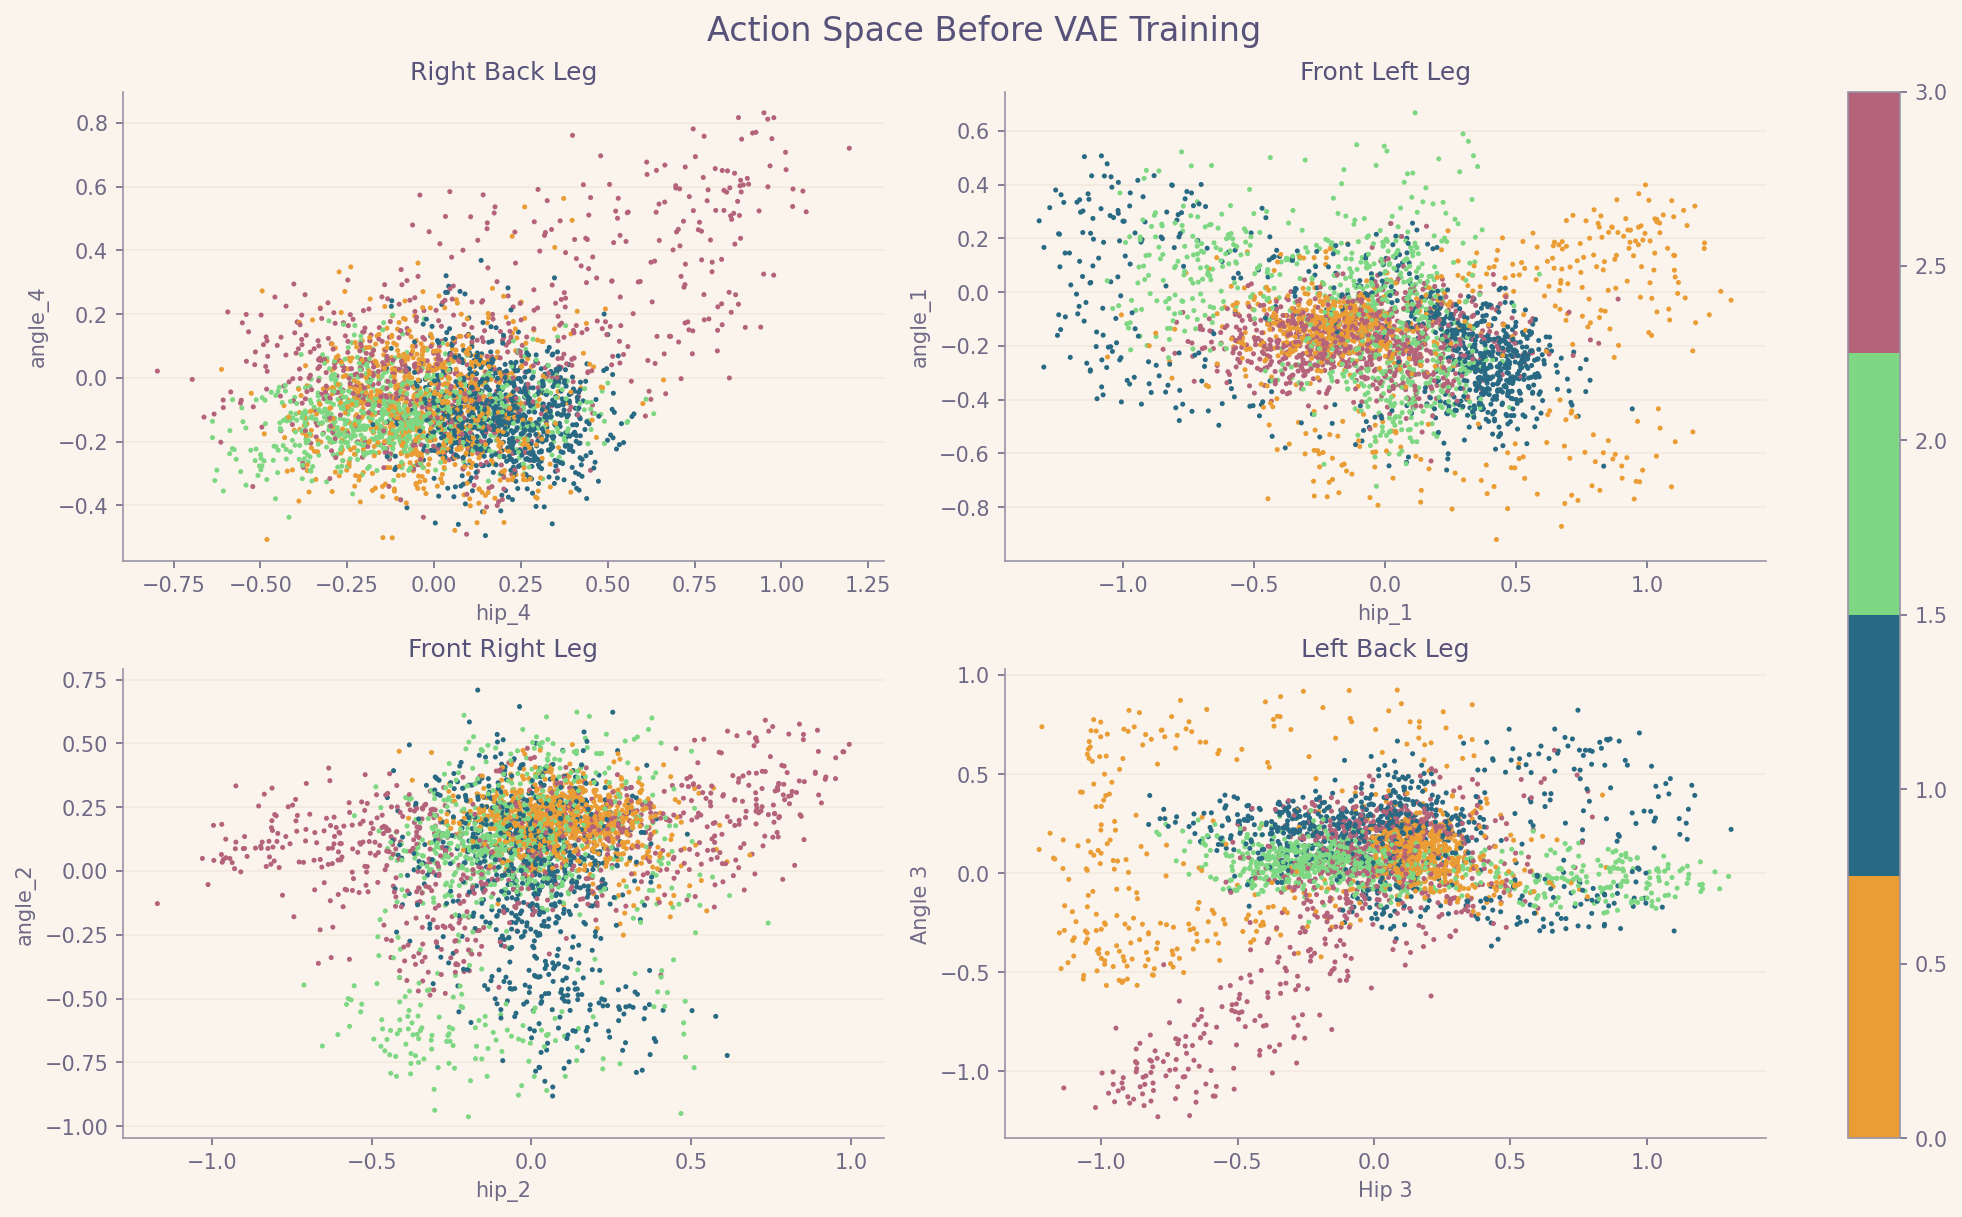

In [163]:
cmap = ListedColormap(['#EA9D34', '#286983', '#7ED782', '#B4637A'])

def action_sapce_before():
    fig, ax = plt.subplots(2, 2, figsize=(13, 8), constrained_layout=True)


    for i, (x, y) in enumerate(dataloader):
        ax[0, 0].scatter(x[:, 0][:, 0], x[:, 0][:, 1], c=y, cmap=cmap, s=2)
        ax[0, 0].set_title('Right Back Leg')
        ax[0, 0].set_xlabel('hip_4')
        ax[0, 0].set_ylabel('angle_4')

        ax[0, 1].scatter(x[:, 0][:, 2], x[:, 0][:, 3], c=y, cmap=cmap, s=2)
        ax[0, 1].set_title('Front Left Leg')
        ax[0, 1].set_xlabel('hip_1')
        ax[0, 1].set_ylabel('angle_1')

        ax[1, 0].scatter(x[:, 0][:, 4], x[:, 0][:, 5], c=y, cmap=cmap, s=2)
        ax[1, 0].set_title('Front Right Leg')
        ax[1, 0].set_xlabel('hip_2')
        ax[1, 0].set_ylabel('angle_2')

        ax[1, 1].scatter(x[:, 0][:, 6], x[:, 0][:, 7], c=y, cmap=cmap, s=2)
        ax[1, 1].set_title('Left Back Leg')
        ax[1, 1].set_xlabel('Hip 3')
        ax[1, 1].set_ylabel('Angle 3')

        if i > 100:
            break

    # Add main title
    plt.suptitle('Action Space Before VAE Training', fontsize=16)

    # Add a legend for the whole figure
    fig.colorbar(ax[0, 0].collections[0], ax=ax.ravel().tolist(), pad=0.05)
    
    # plt.savefig('AppoVariations.png', dpi=300)
    plt.show()

action_sapce_before()

In [133]:
# Initialize the model
num_features = 8
latent_dims = 2

In [134]:
def save_model(vae, model_path):
    """
    Save the trained VAE model.
    """
    torch.save(vae.state_dict(), model_path)

def load_model(vae, model_path):
    """
    Load a trained VAE model.
    """
    vae.load_state_dict(torch.load(model_path, map_location=device))

In [137]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(8, 5)
        self.linear2 = nn.Linear(5, latent_dims)
        self.linear3 = nn.Linear(5, latent_dims)

        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.leaky_relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        # z = mu + sigma*self.N.sample(mu.shape)
        z = mu + sigma
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 5)
        self.linear2 = nn.Linear(5, 8)

    def forward(self, z):
        z = F.leaky_relu(self.linear1(z))
        # z = torch.sigmoid(self.linear2(z))
        z = (self.linear2(z))
        return z.reshape((-1, 1, 8))
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            print(x.shape)
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            print(loss)
            loss.backward()
            opt.step()
    return autoencoder

In [138]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, train_dataloader, 5)

torch.Size([32, 8])
tensor(3018.5483, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2893.7603, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(3093.4465, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2730.6602, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2719.1226, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2836.0476, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2830.5654, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2846.6743, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2562.4470, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2644.9387, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2545.4980, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2510.8096, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2554.6387, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2426.2605, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2464.6438, grad_fn=<AddBackward0>)
torch.Size([32, 8])
tensor(2558.9385, grad_fn=<AddBackward0>)
torch.Si

IndexError: index 360000 is out of bounds for dimension 0 with size 360000

In [231]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    fig, ax = plt.subplots(2, 2, figsize=(13, 8), constrained_layout=True)

    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 1, 8)
            # print(in_pic)
            
            ax[0, 0].scatter(in_pic[:, 0][:, 0], in_pic[:, 0][:, 1], s=2)
            ax[0, 0].set_title('Right Back Leg')
            ax[0, 0].set_xlabel('hip_4')
            ax[0, 0].set_ylabel('angle_4')

            ax[0, 1].scatter(in_pic[:, 0][:, 2], in_pic[:, 0][:, 3], s=2)
            ax[0, 1].set_title('Front Left Leg')
            ax[0, 1].set_xlabel('hip_1')
            ax[0, 1].set_ylabel('angle_1')

        out_pic = out.data.cpu().view(-1, 1, 8)
        # print(out_pic)
        ax[1, 0].scatter(out_pic[:, 0][:, 4], out_pic[:, 0][:, 5], s=2)
        ax[1, 0].set_title('Front Right Leg')
        ax[1, 0].set_xlabel('hip_2')
        ax[1, 0].set_ylabel('angle_2')

        ax[1, 1].scatter(out_pic[:, 0][:, 6], out_pic[:, 0][:, 7],  s=2)
        ax[1, 1].set_title('Left Back Leg')
        ax[1, 1].set_xlabel('Hip 3')
        ax[1, 1].set_ylabel('Angle 3')

    # Add main title
    plt.suptitle('Action Space After VAE Training', fontsize=16)

    # Add a legend for the whole figure
    fig.colorbar(ax[0, 0].collections[0], ax=ax.ravel().tolist(), pad=0.05)
    
    # plt.savefig('AppoVariations.png', dpi=300)
    plt.show()

In [239]:
# Defining the model

d = 2

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(8, d ** 2),
            nn.LeakyReLU(),
            nn.Linear(d ** 2, d * 2),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.LeakyReLU(),
            nn.Linear(d ** 2, 8),
            nn.Tanh(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 8)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [240]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [241]:
# # Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    # BCE = nn.functional.binary_cross_entropy(
    #     x_hat, x.view(-1, 8), reduction='sum'
    # )
    MSE = nn.functional.mse_loss(x_hat, x.view(-1, 8))
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return MSE + β * KLD


# def loss_function(x_hat, x, mu, logvar, β=1):
#     MSE = nn.MSELoss()(x_hat, x.view(-1, 8))
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return MSE + β * KLD

====> Test set loss: 0.0080


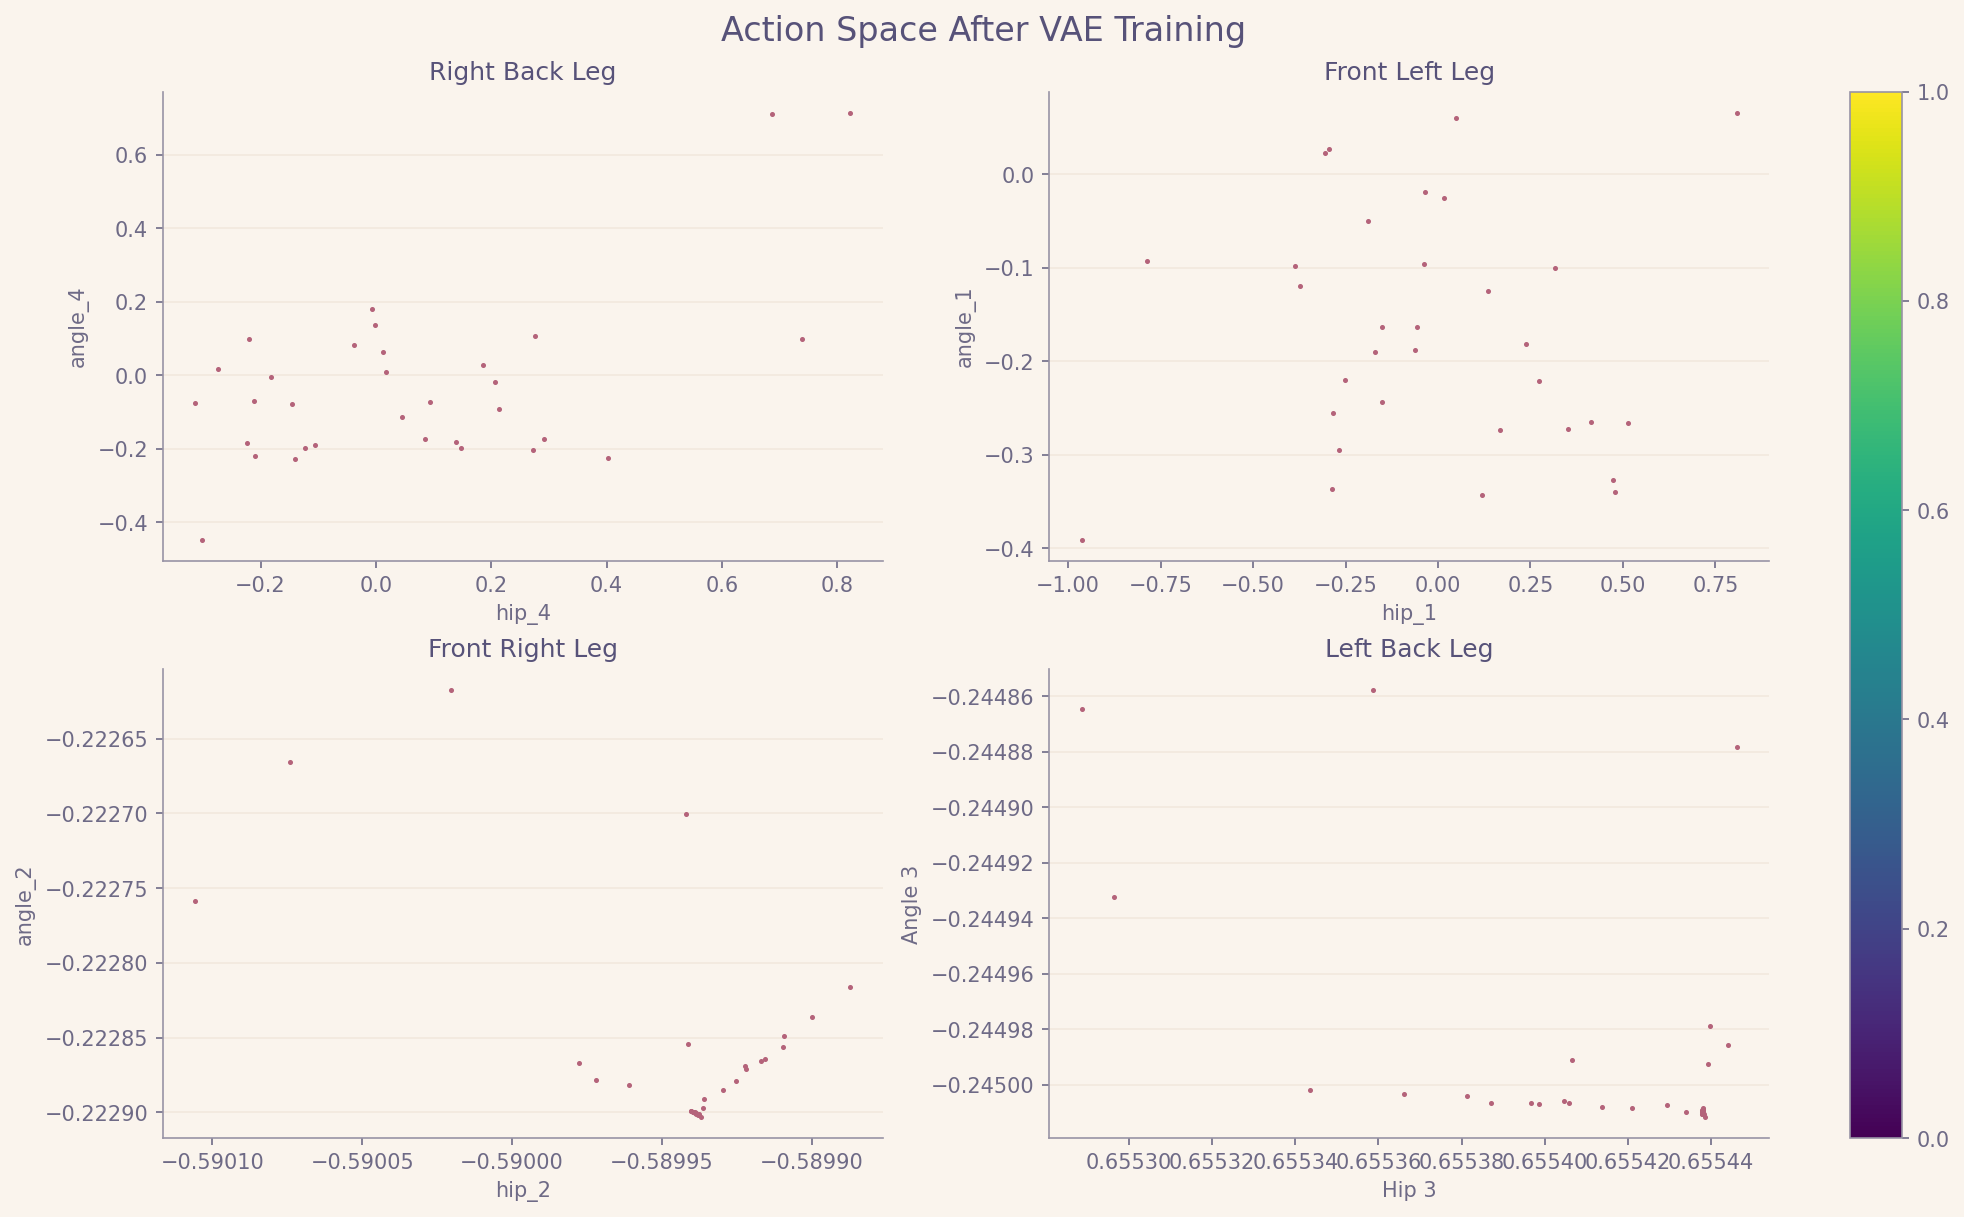

====> Epoch: 1 Average loss: 0.0027
====> Test set loss: 0.0030


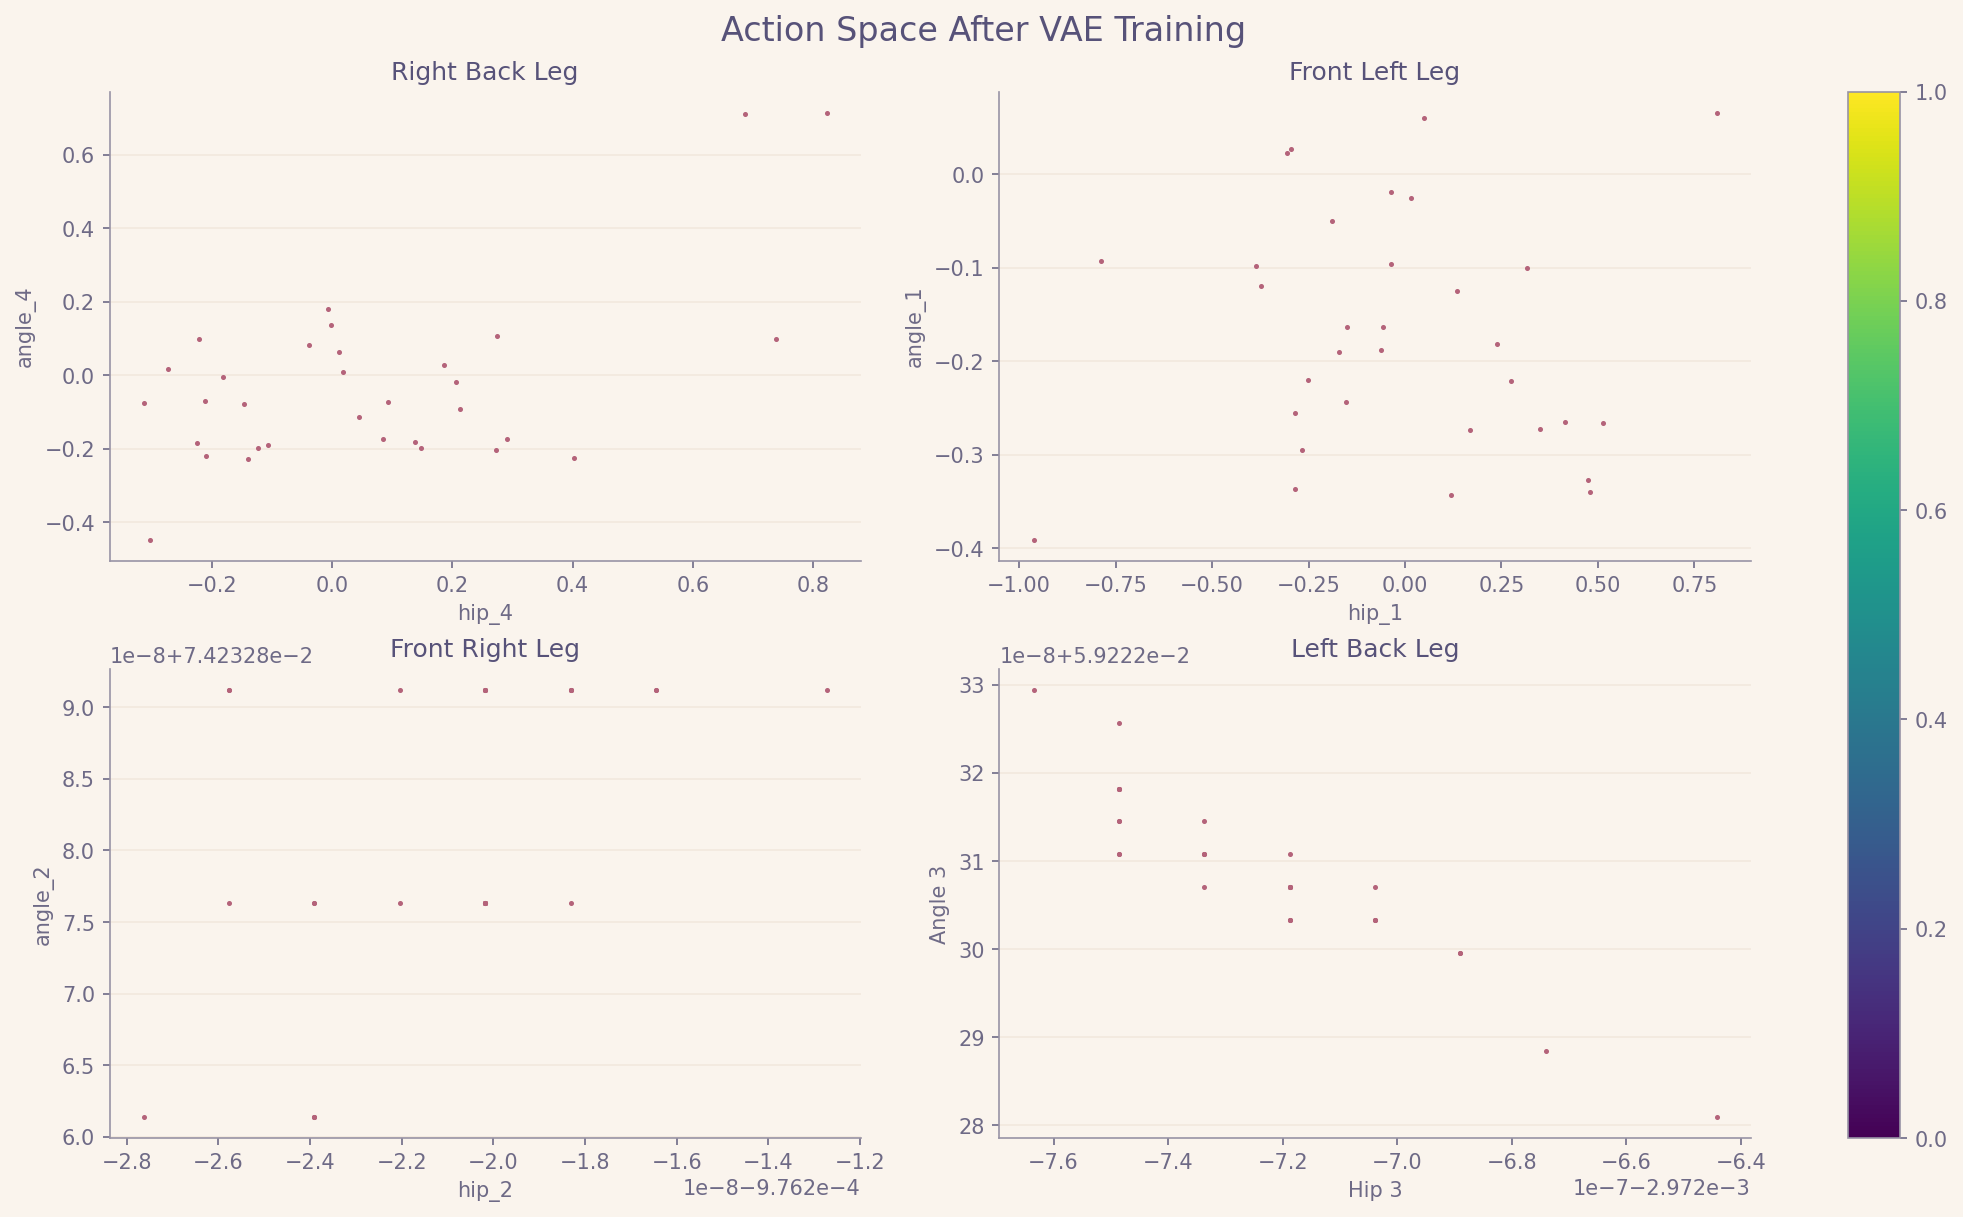

====> Epoch: 2 Average loss: 0.0027
====> Test set loss: 0.0030


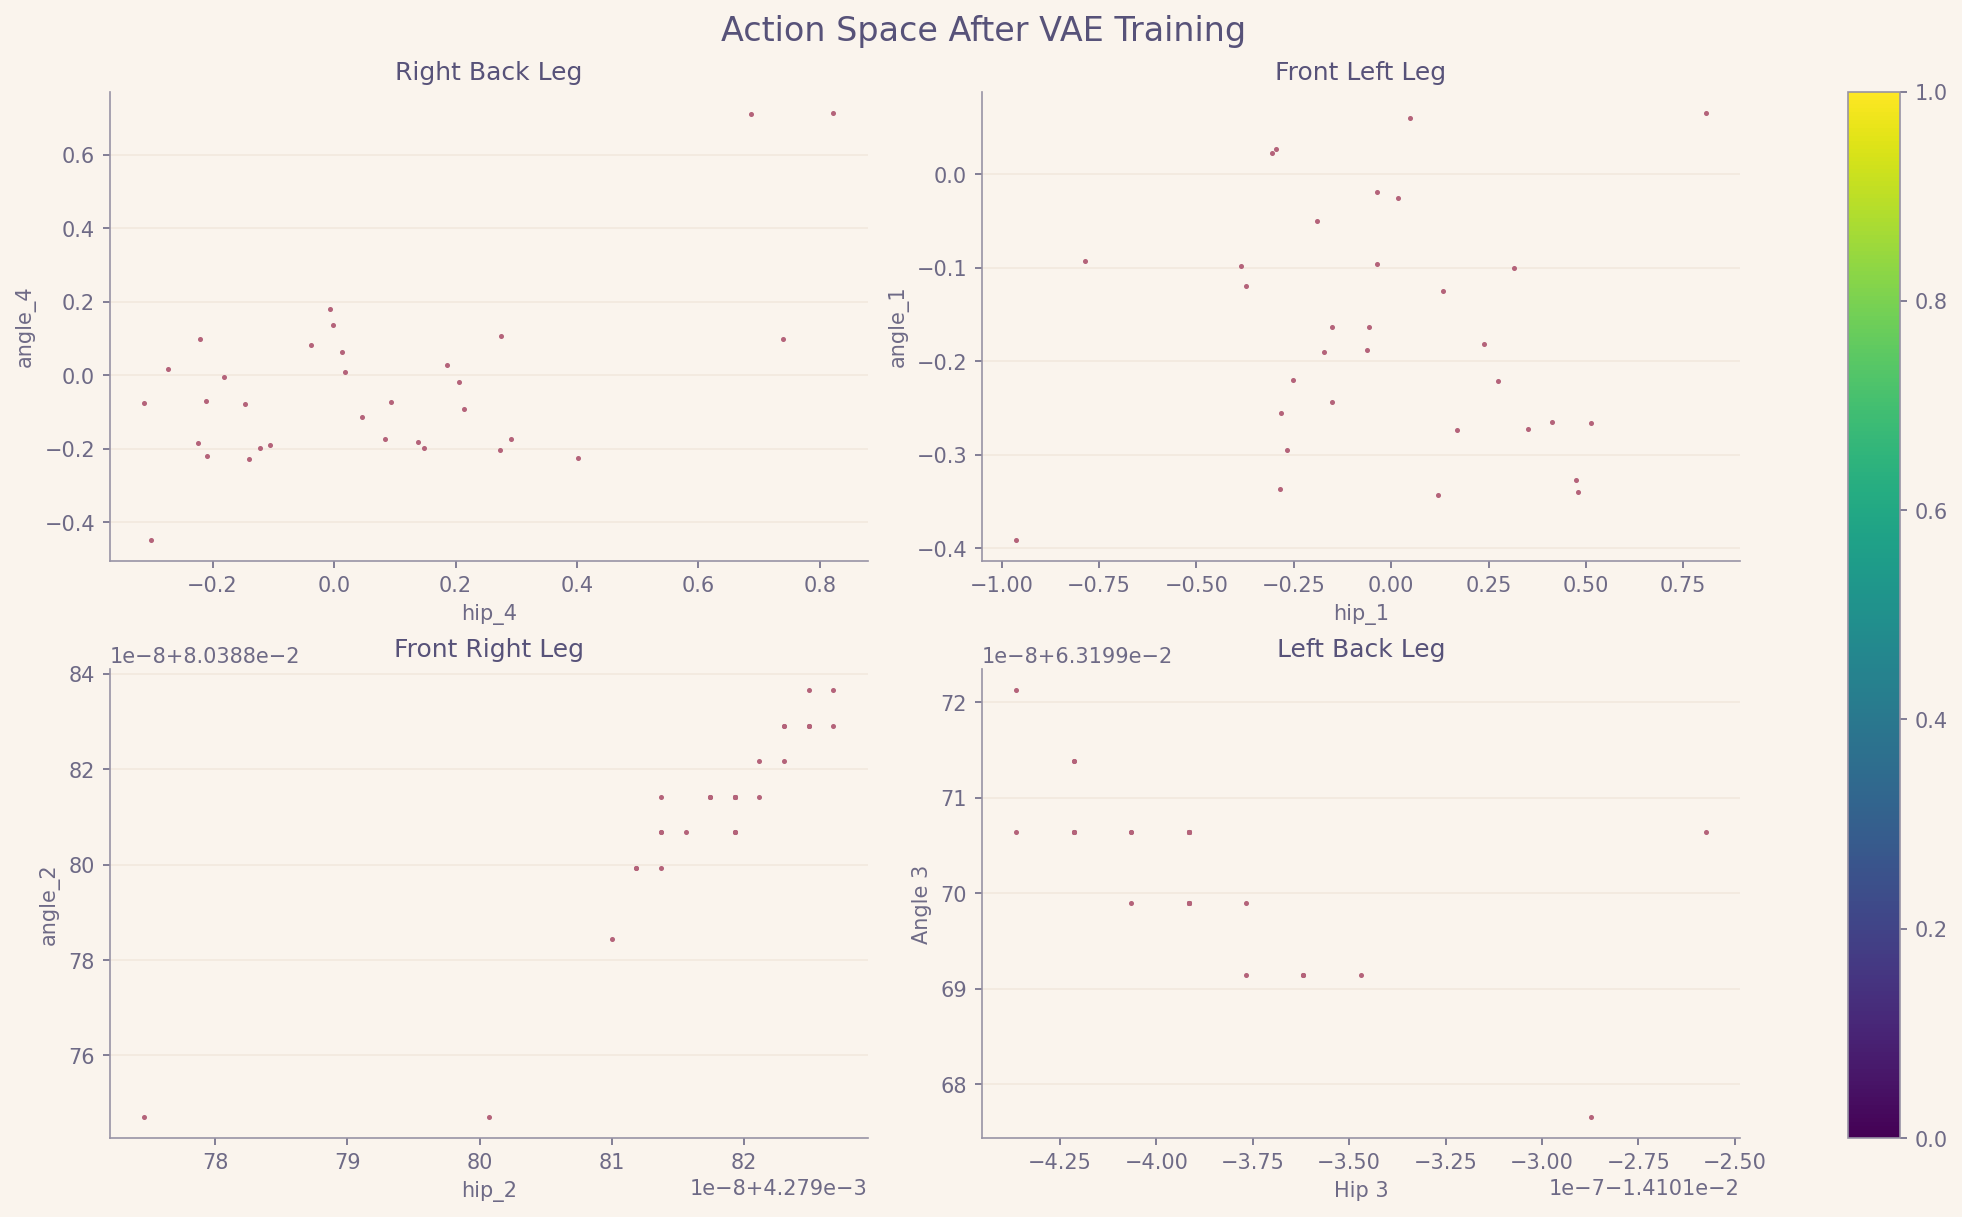

====> Epoch: 3 Average loss: 0.0027
====> Test set loss: 0.0030


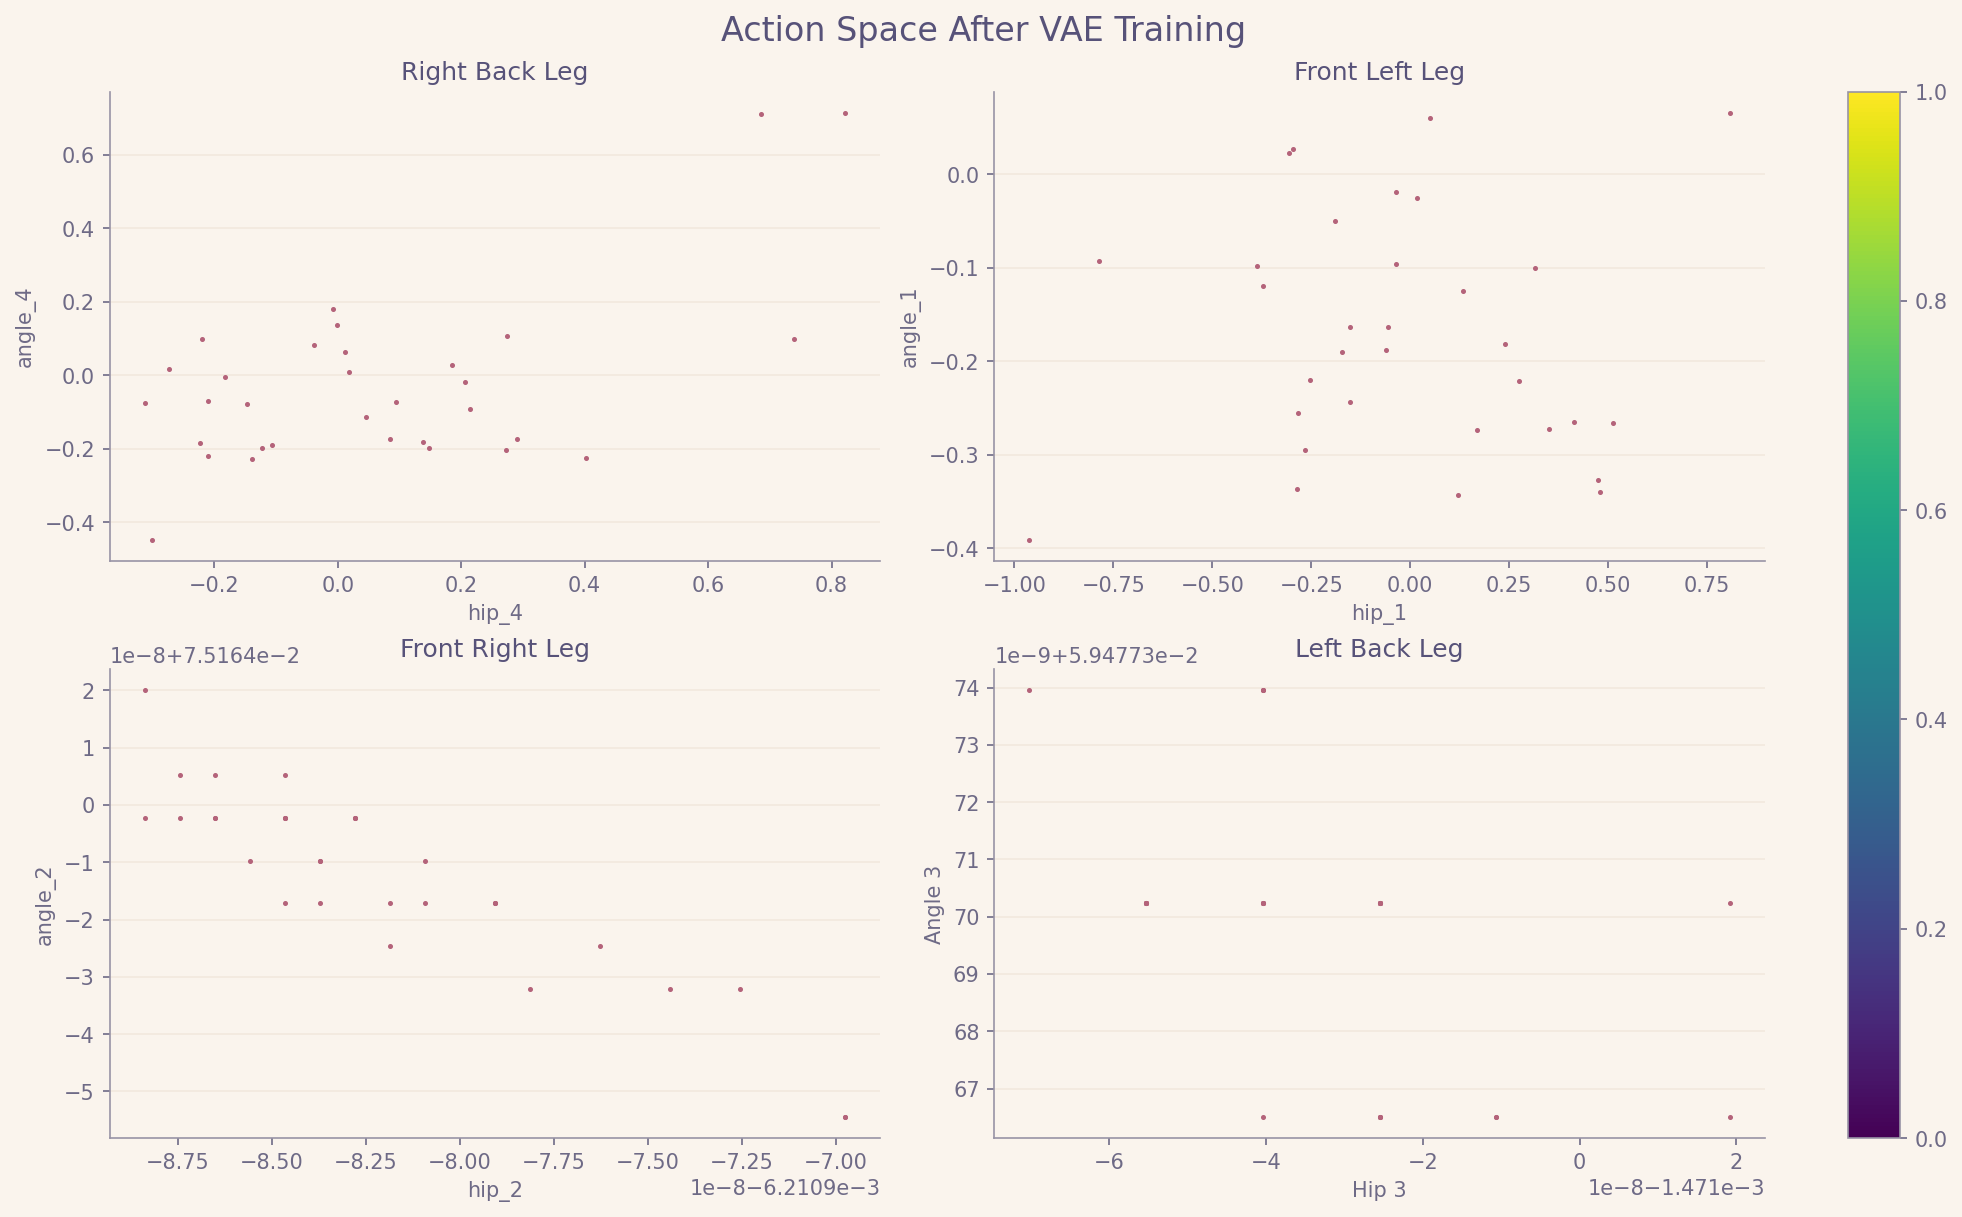

====> Epoch: 4 Average loss: 0.0027
====> Test set loss: 0.0030


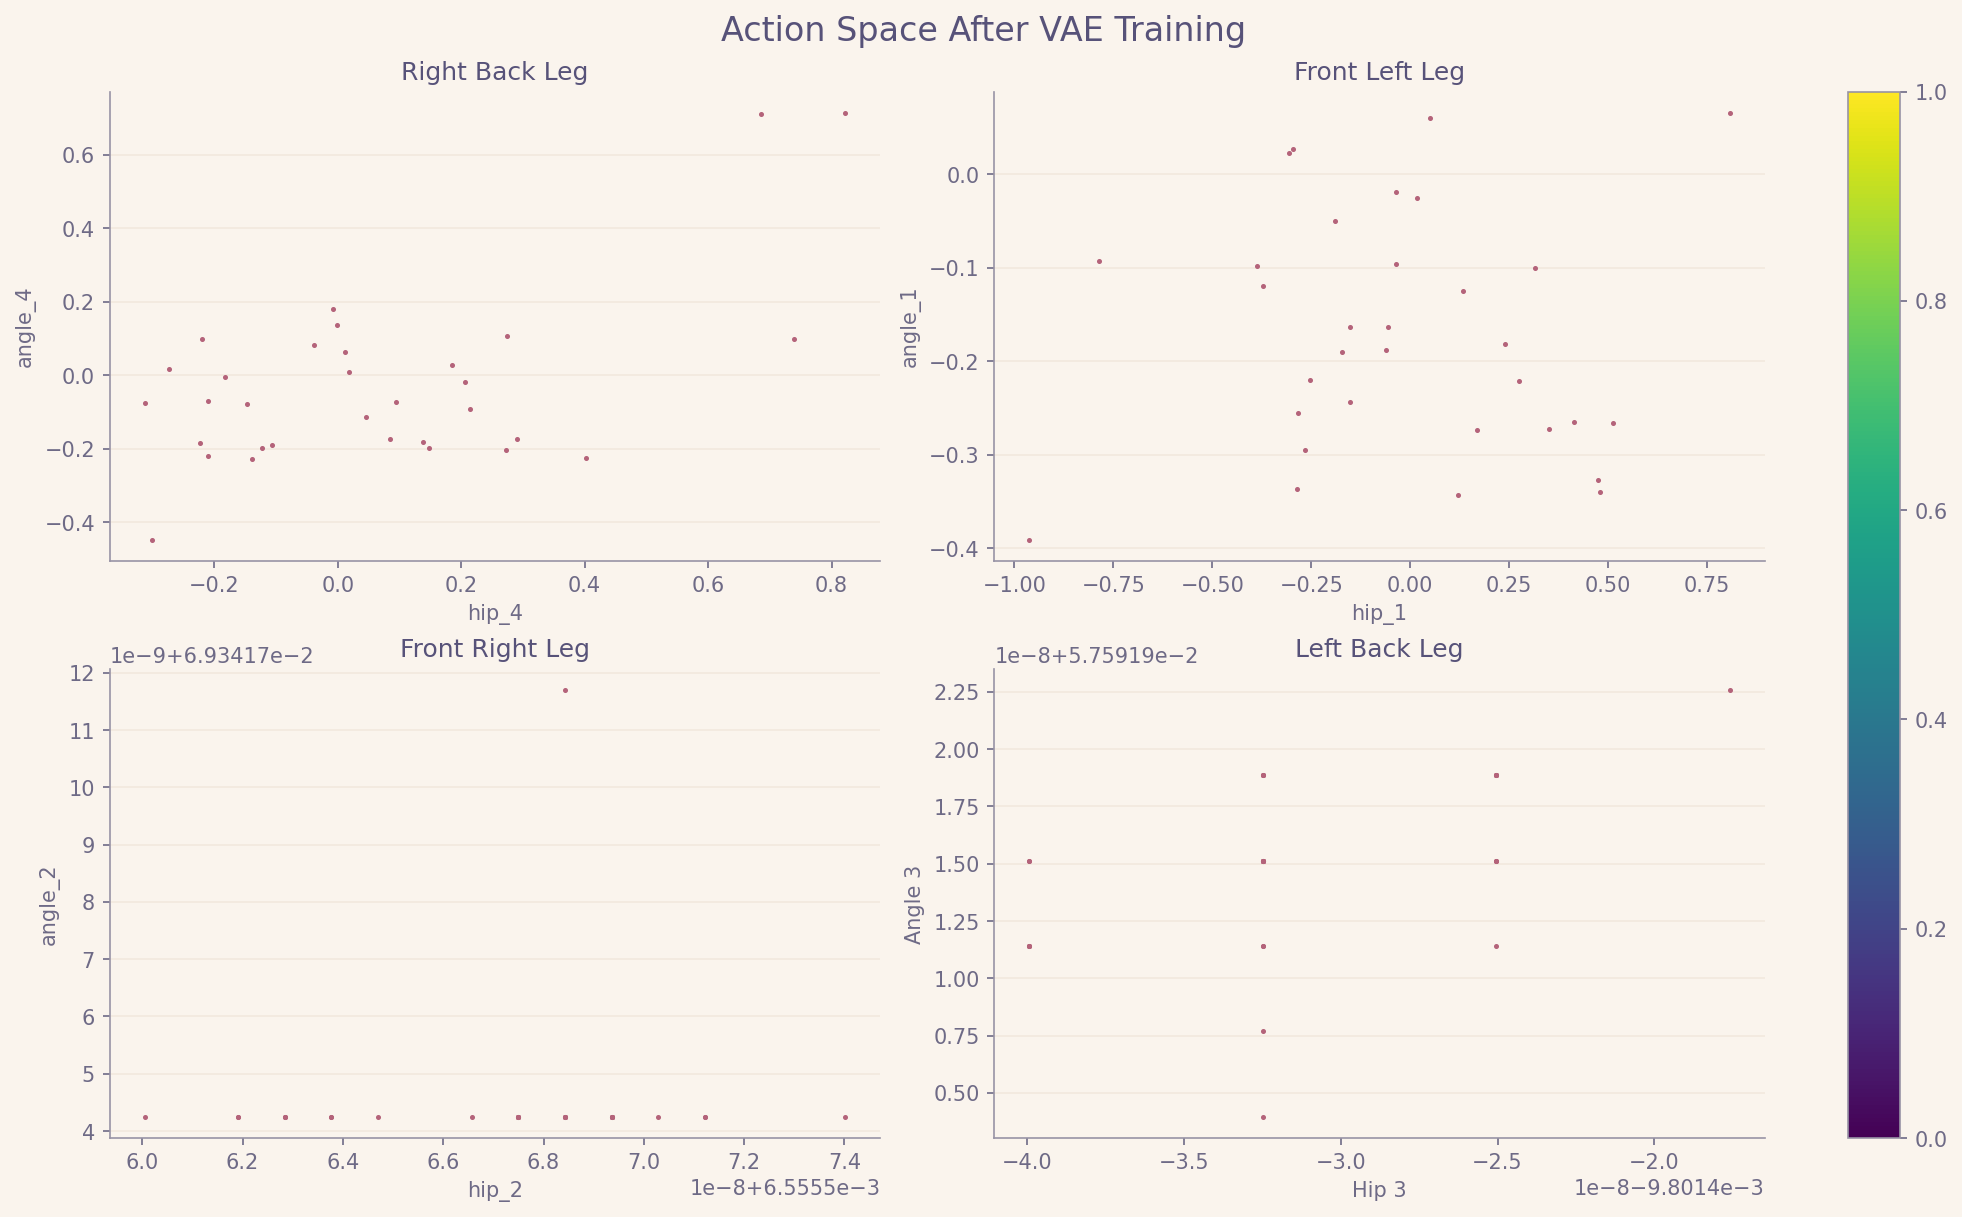

====> Epoch: 5 Average loss: 0.0027
====> Test set loss: 0.0030


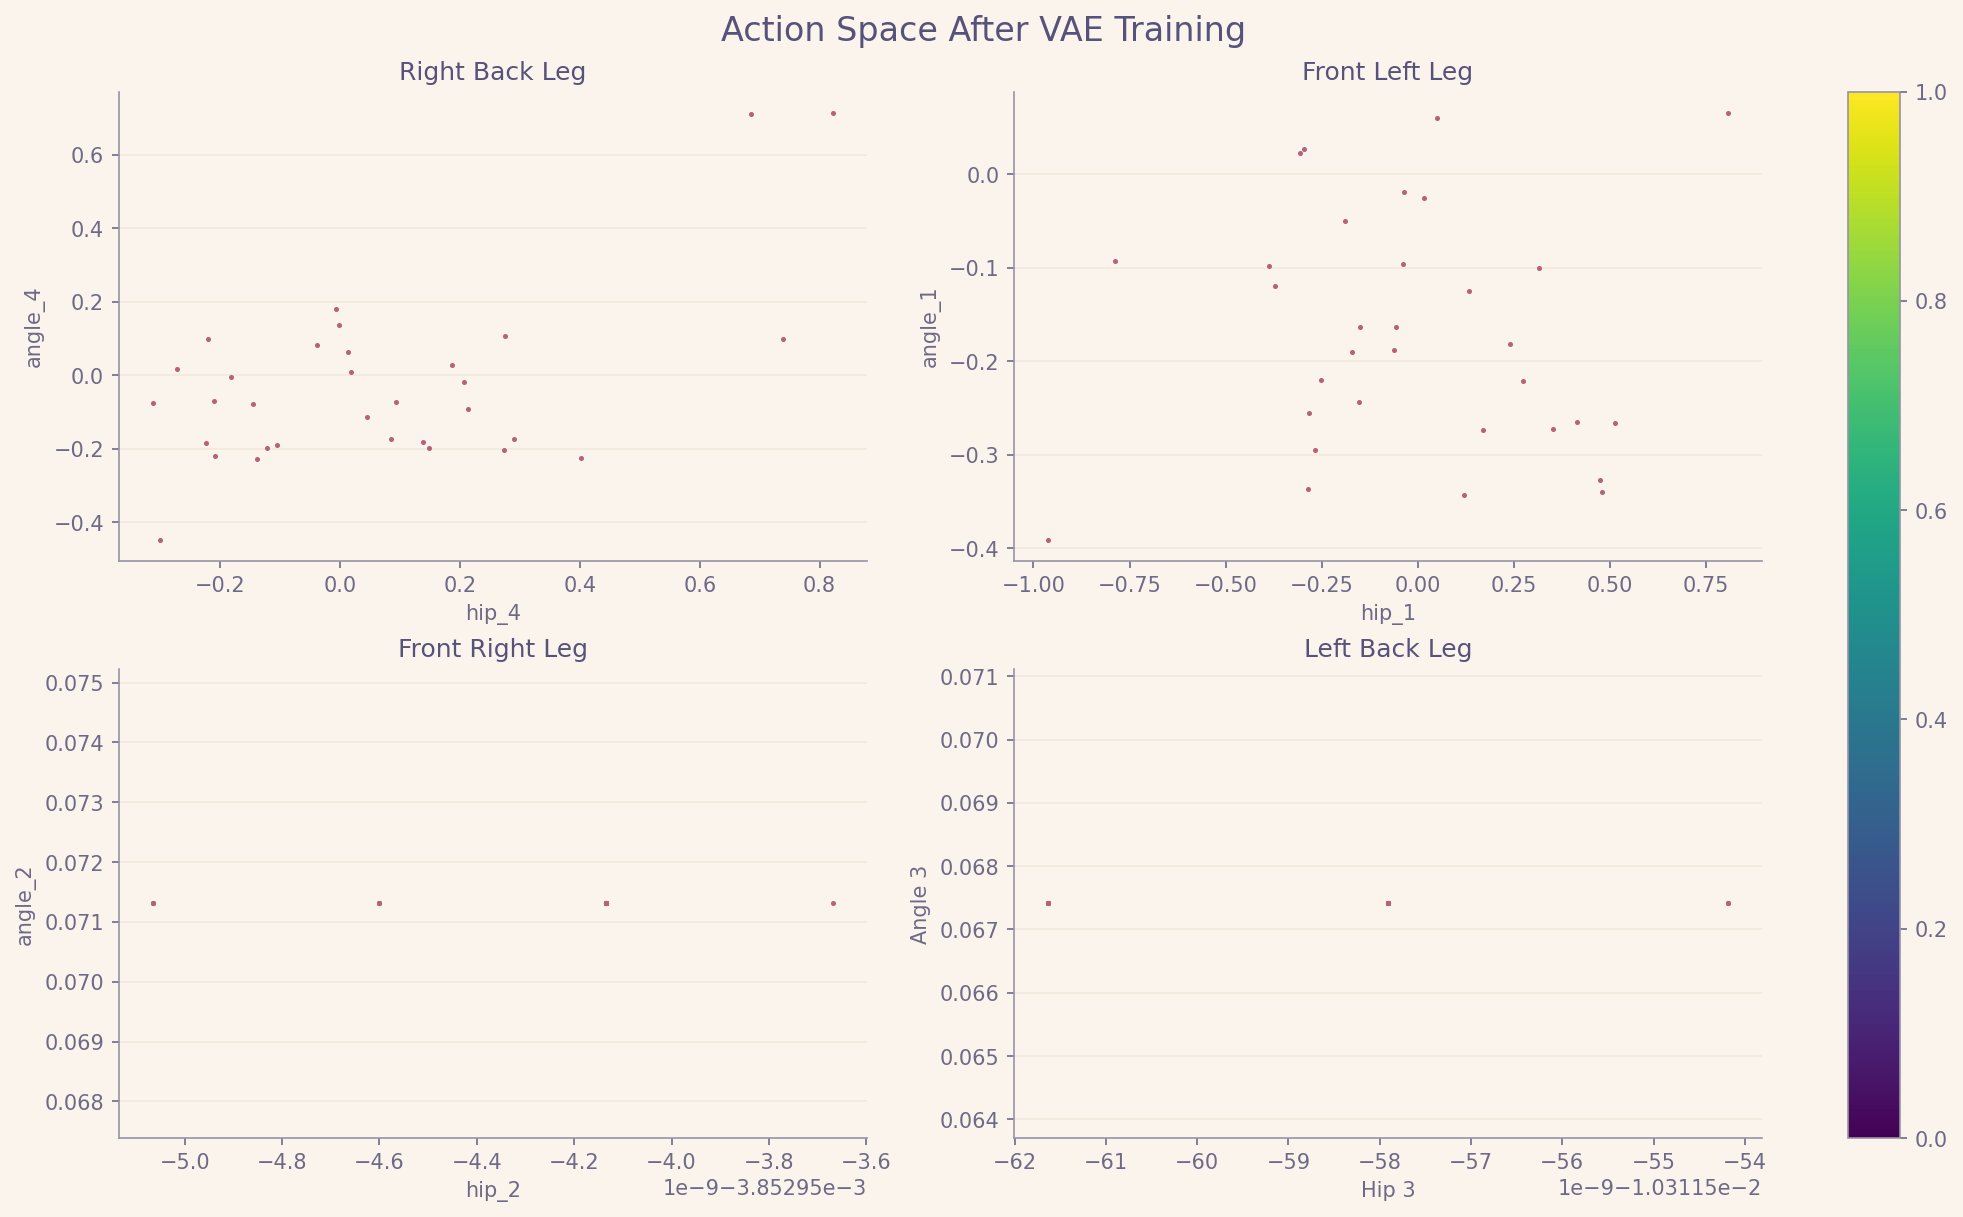

====> Epoch: 6 Average loss: 0.0027
====> Test set loss: 0.0030


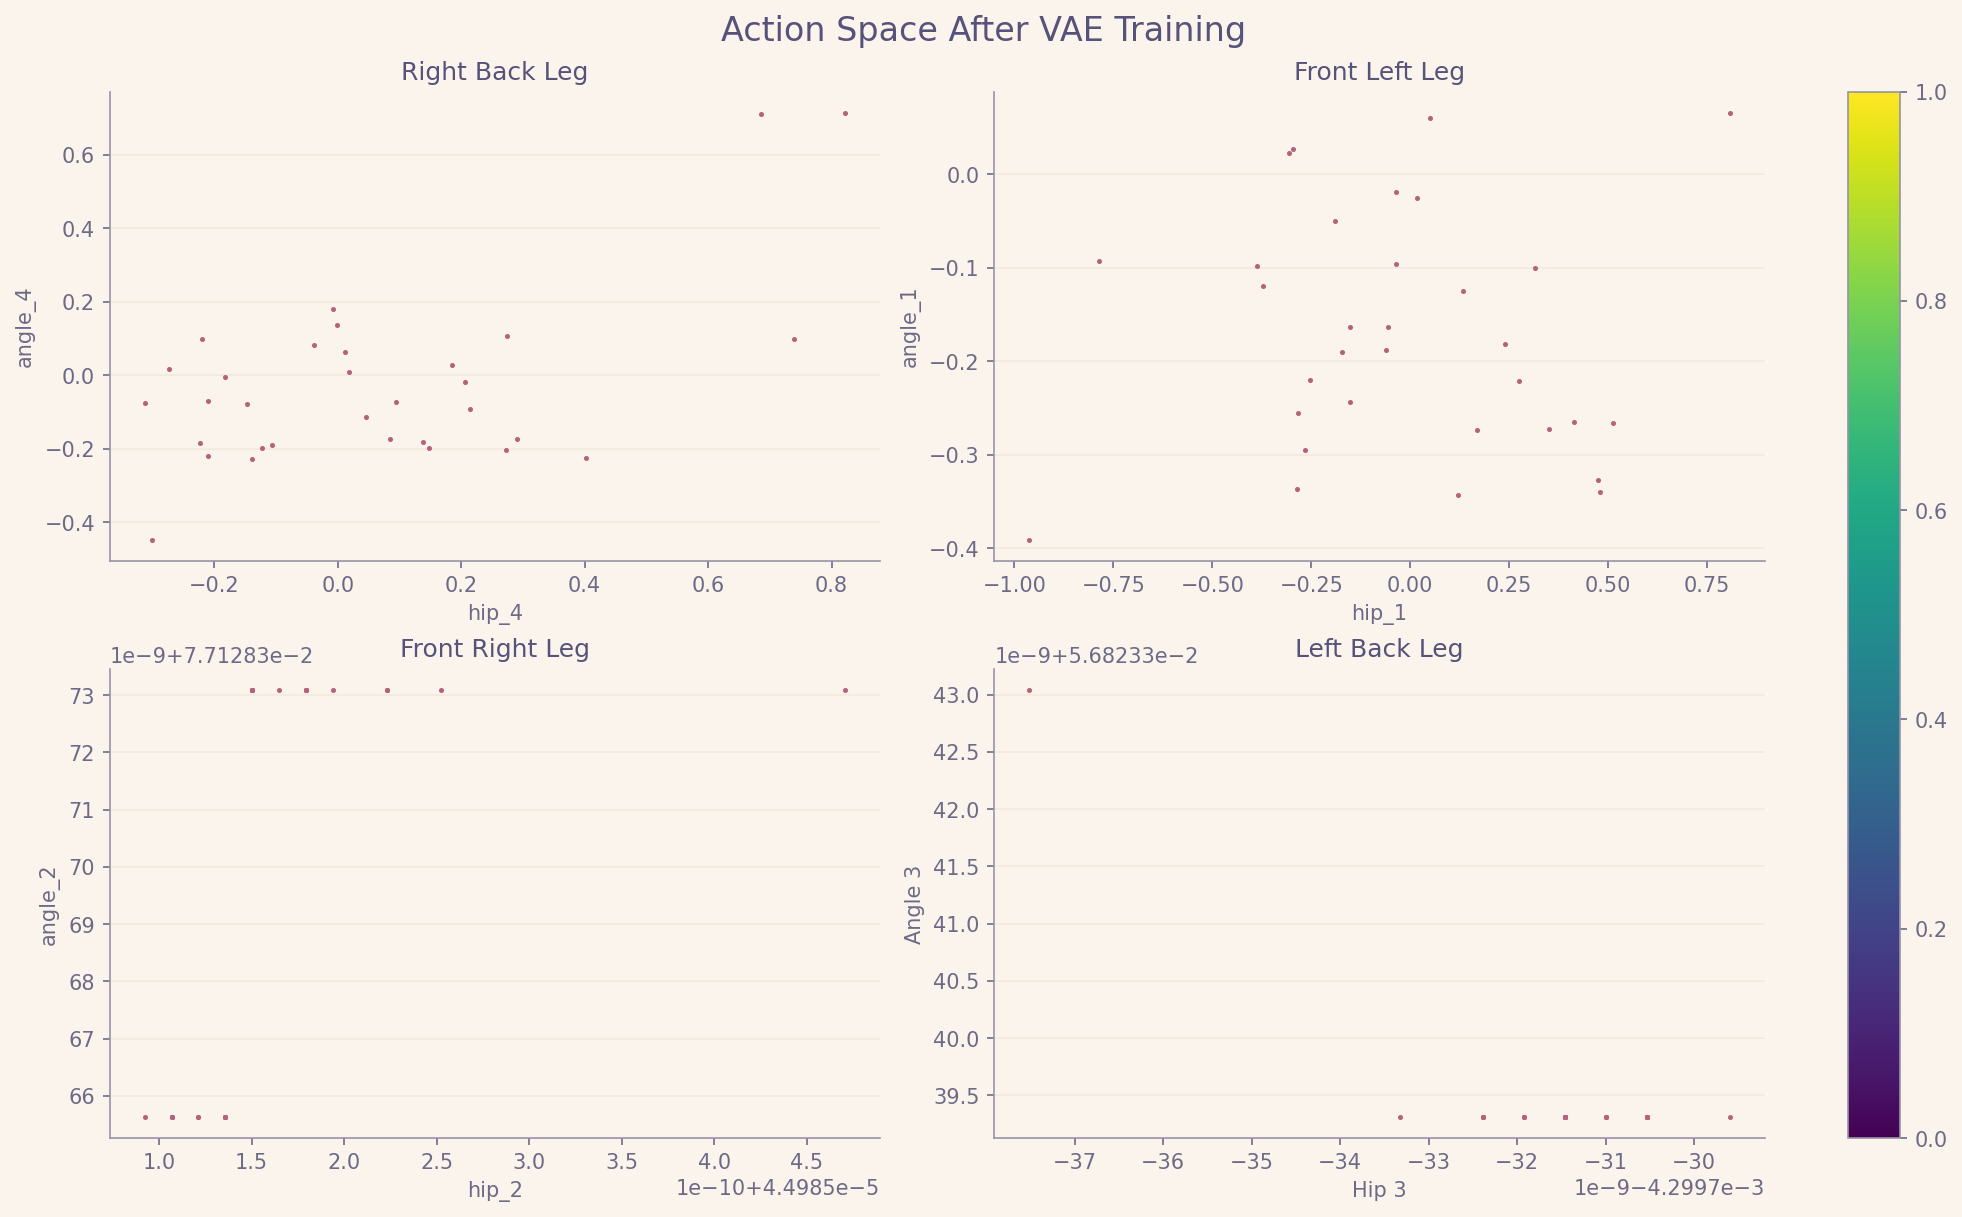

====> Epoch: 7 Average loss: 0.0027
====> Test set loss: 0.0030


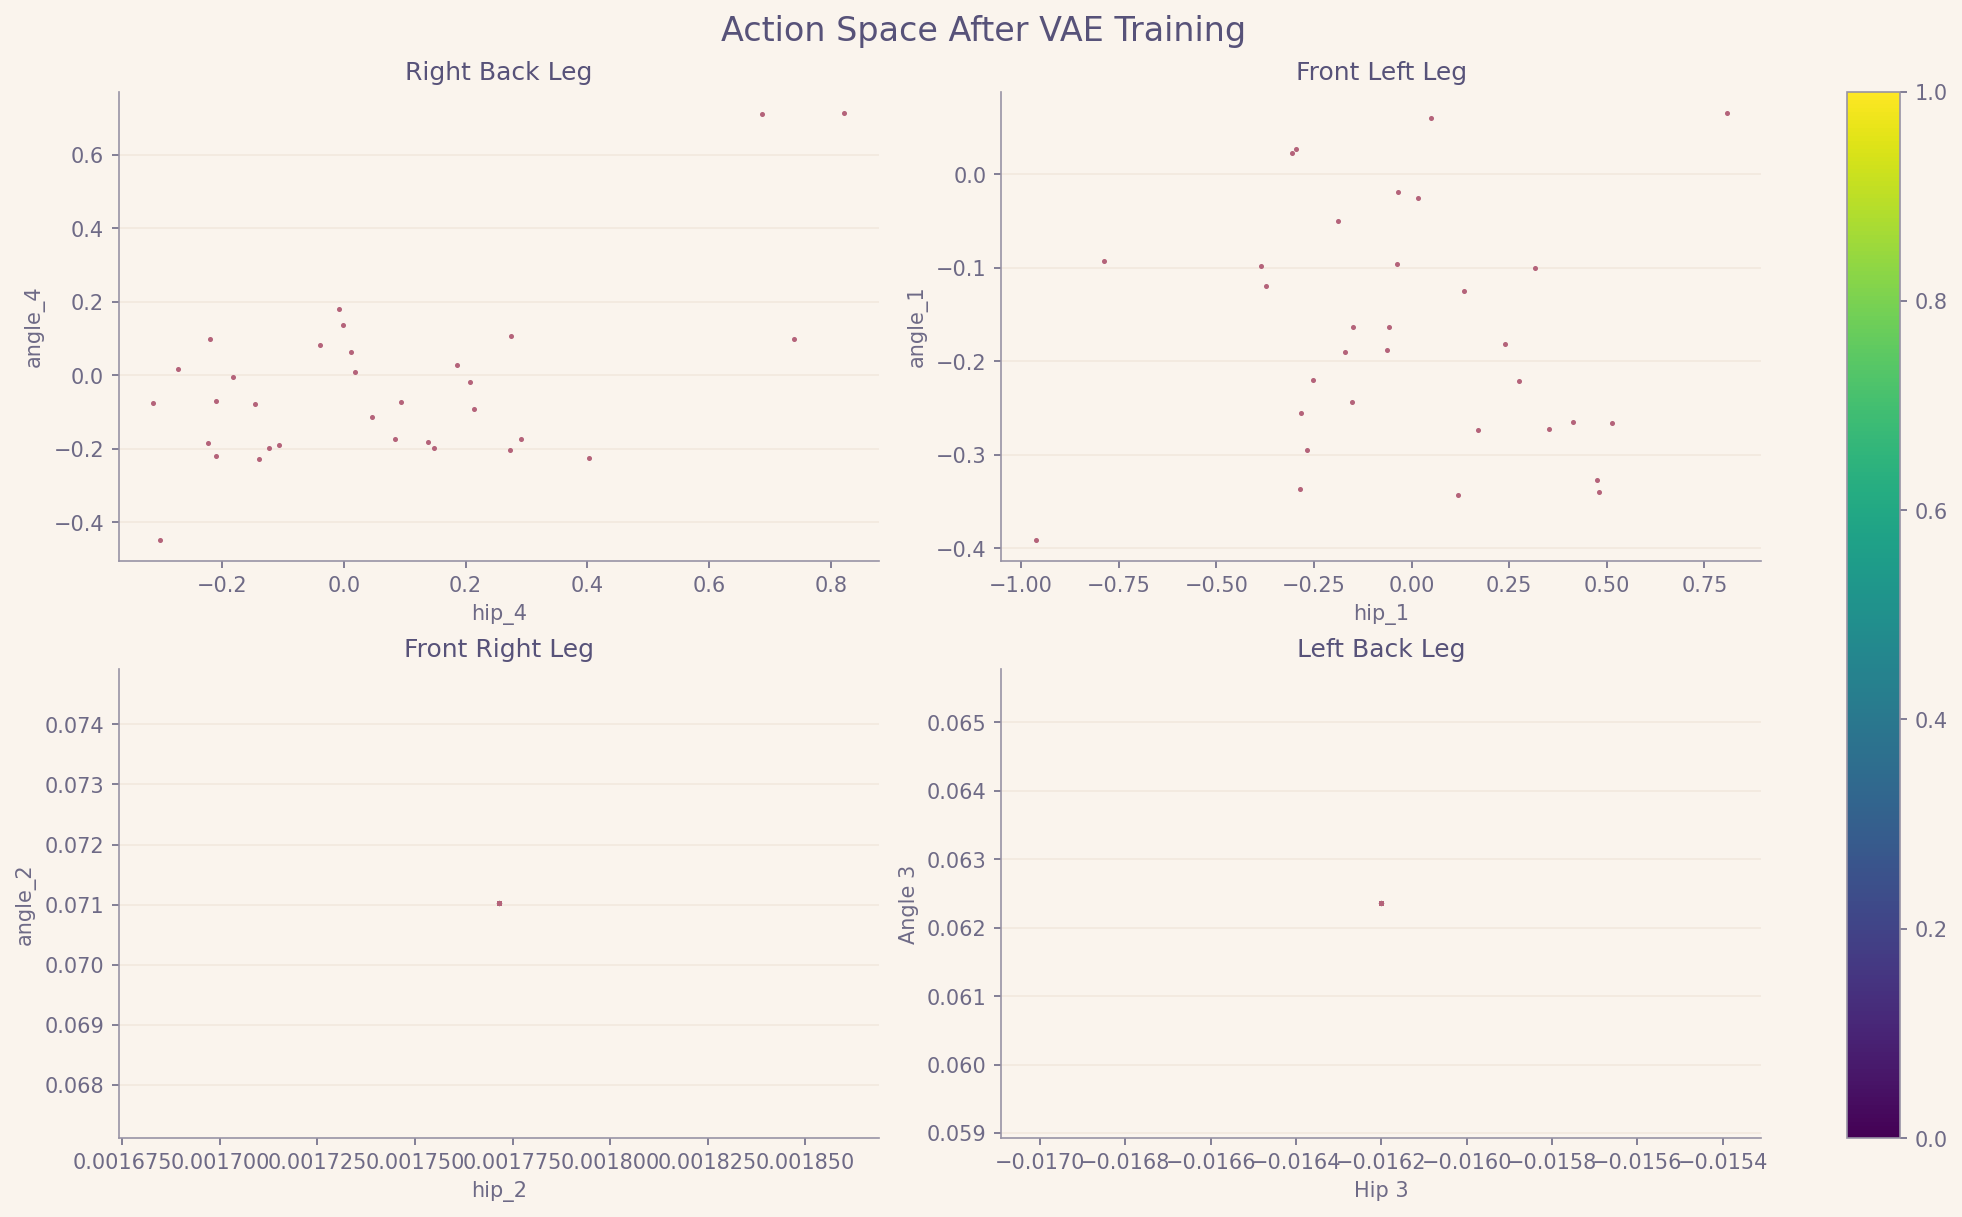

====> Epoch: 8 Average loss: 0.0027
====> Test set loss: 0.0030


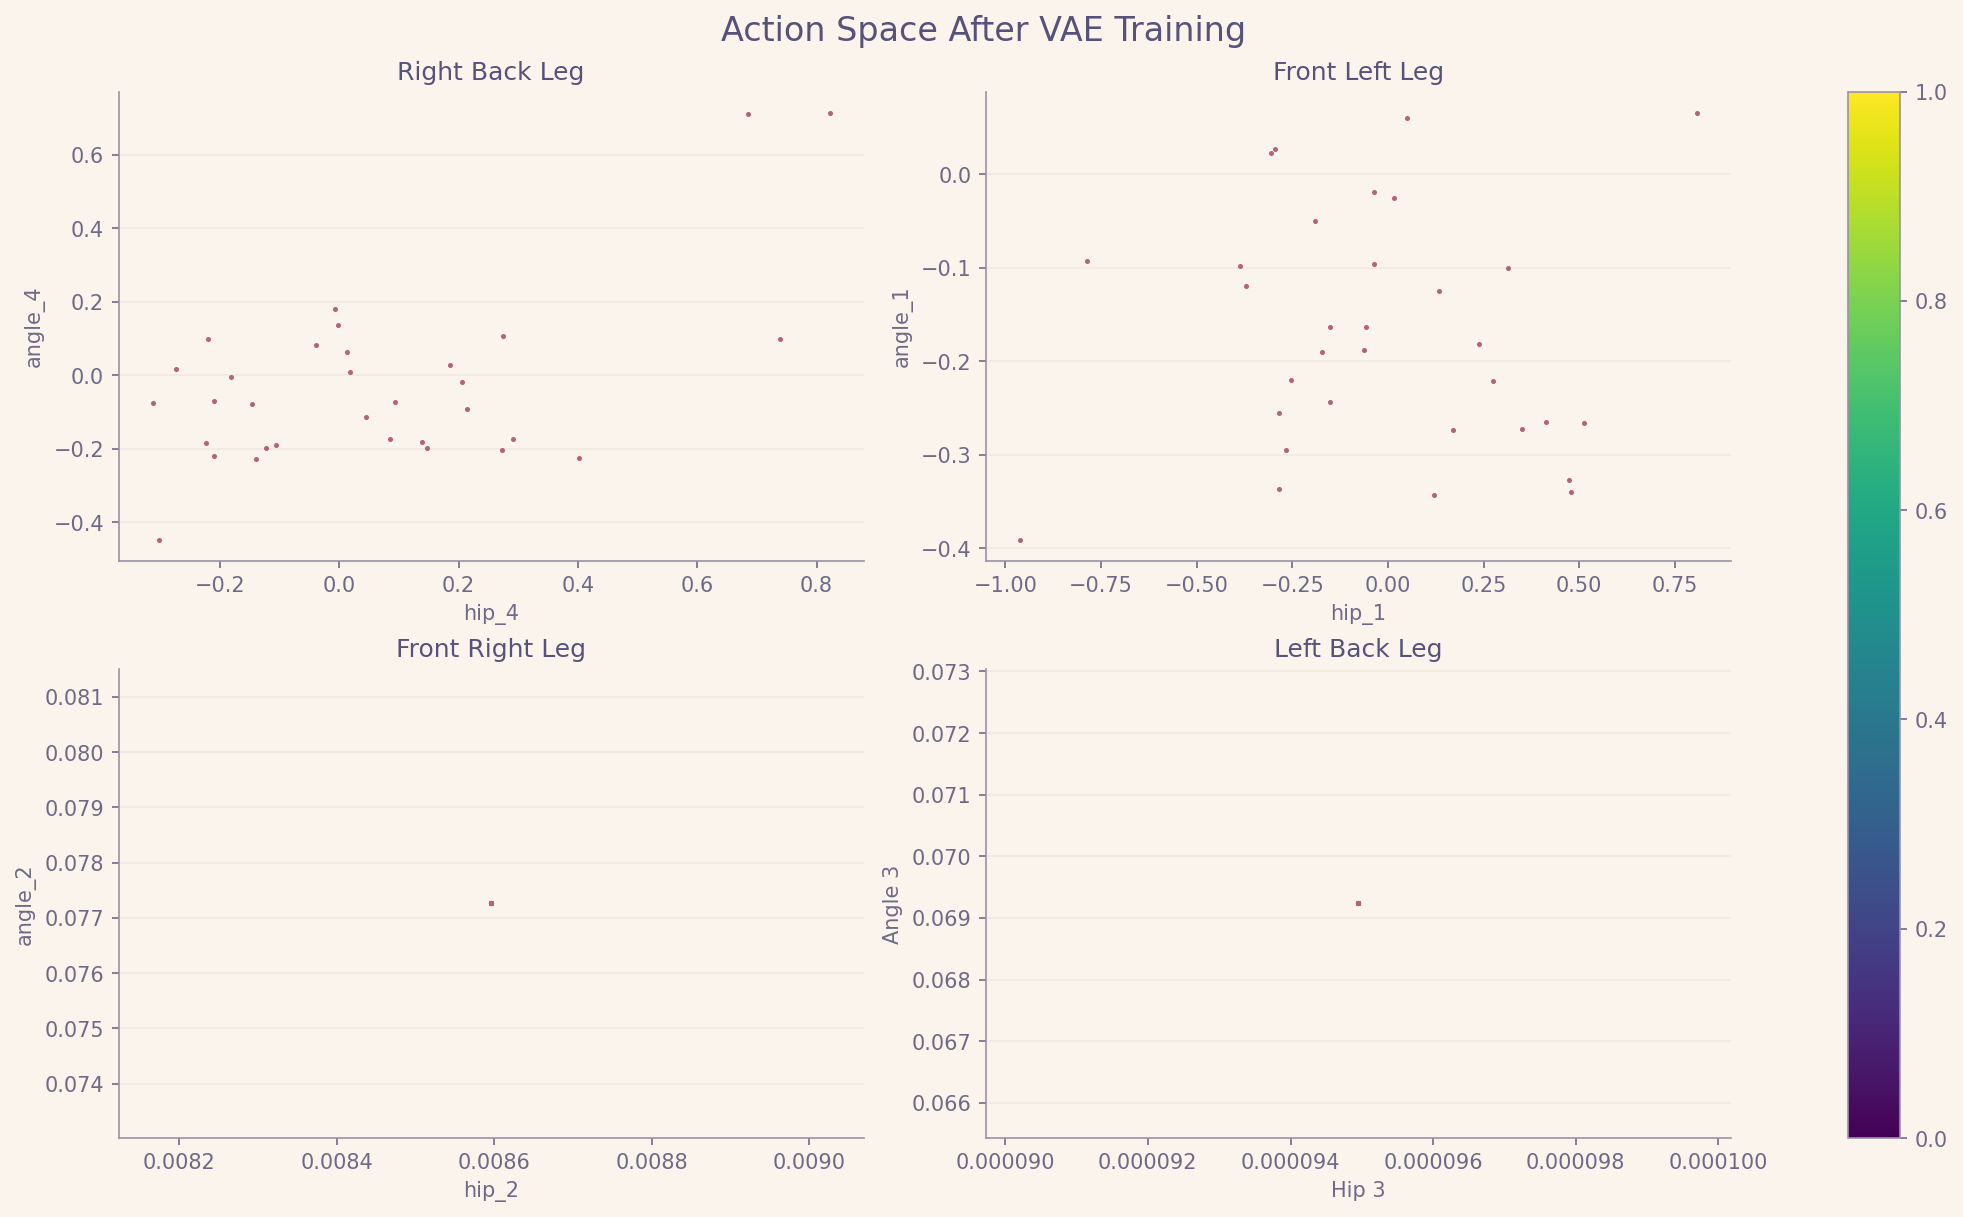

====> Epoch: 9 Average loss: 0.0027
====> Test set loss: 0.0030


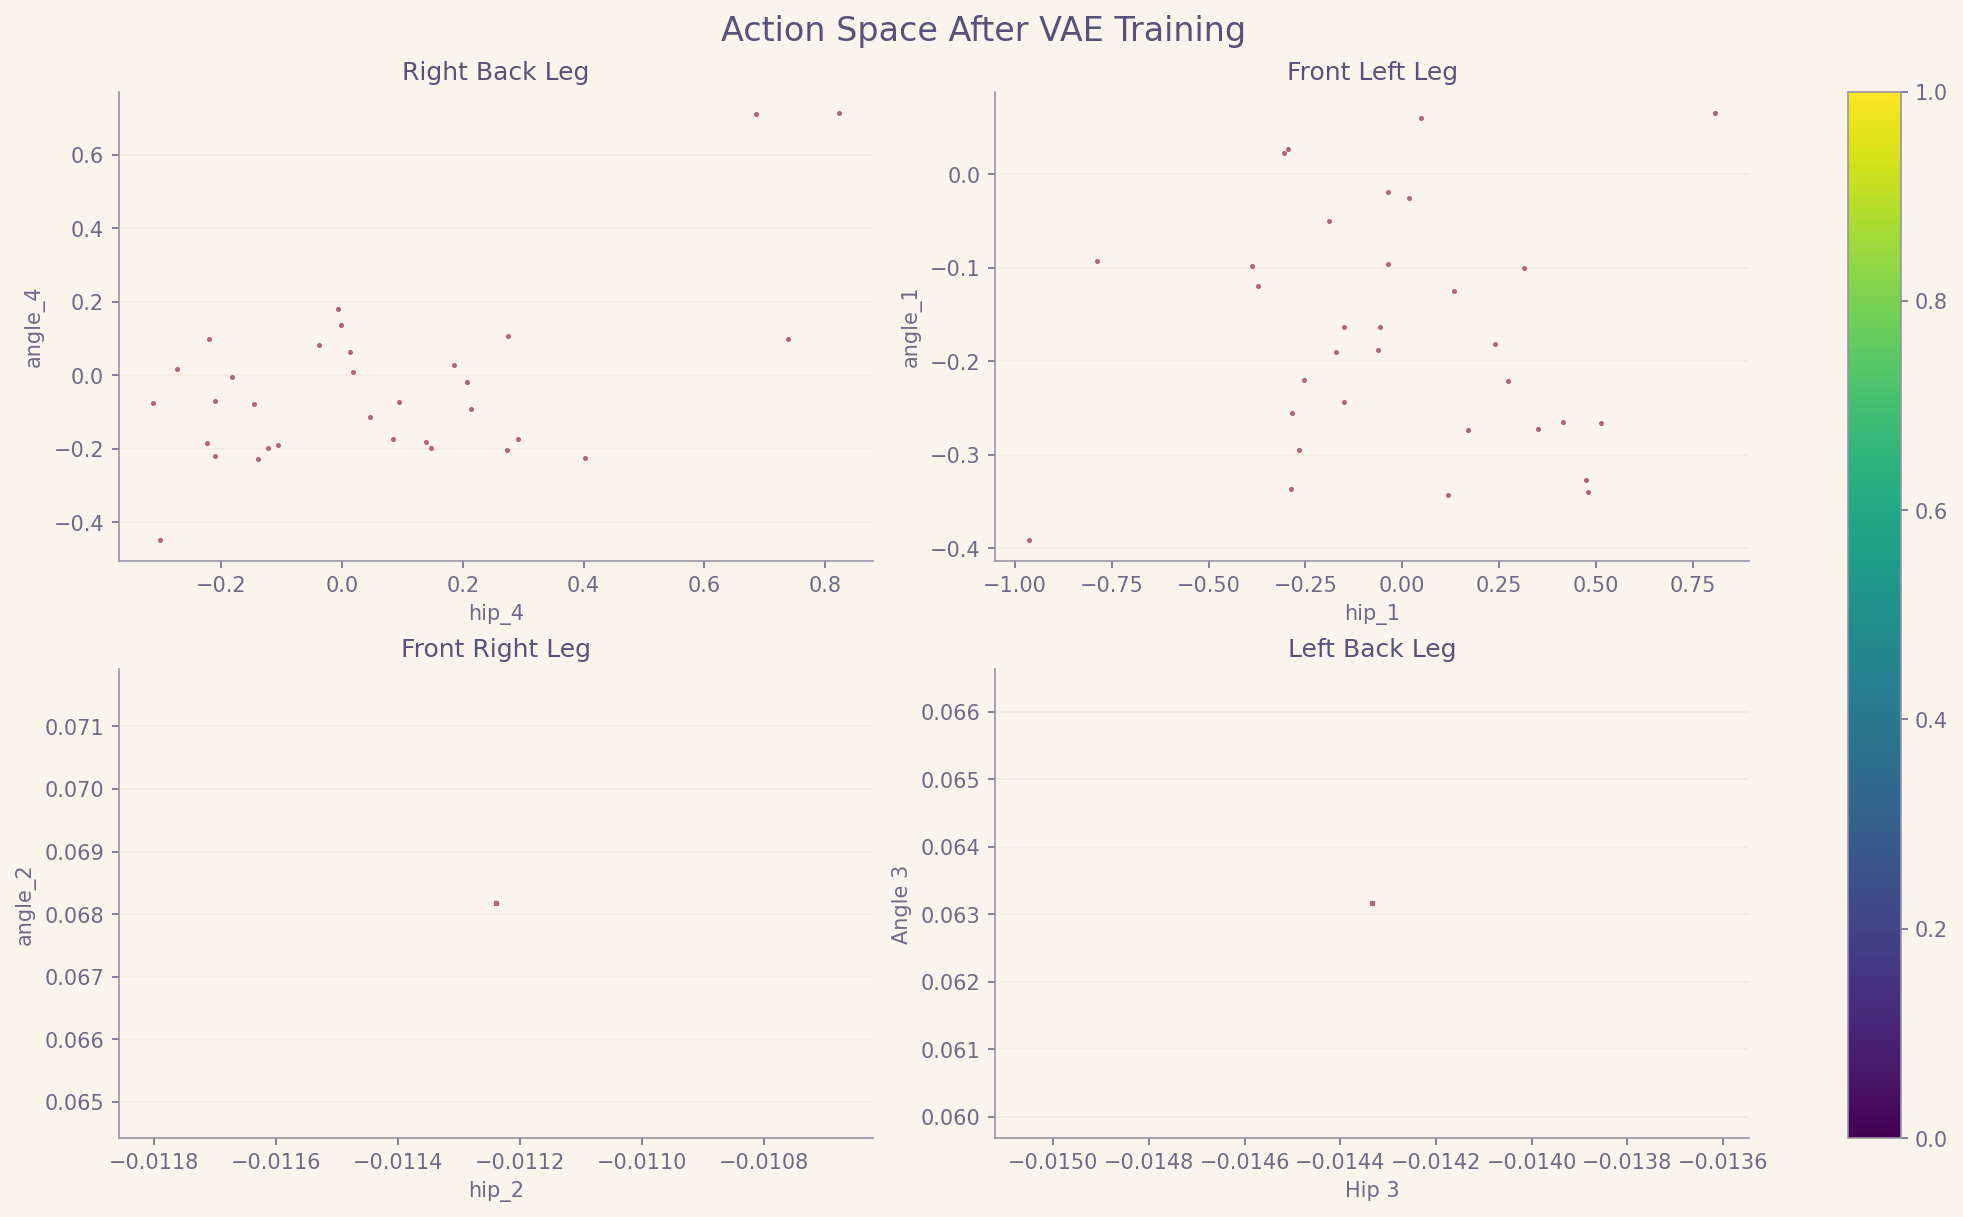

====> Epoch: 10 Average loss: 0.0027
====> Test set loss: 0.0030


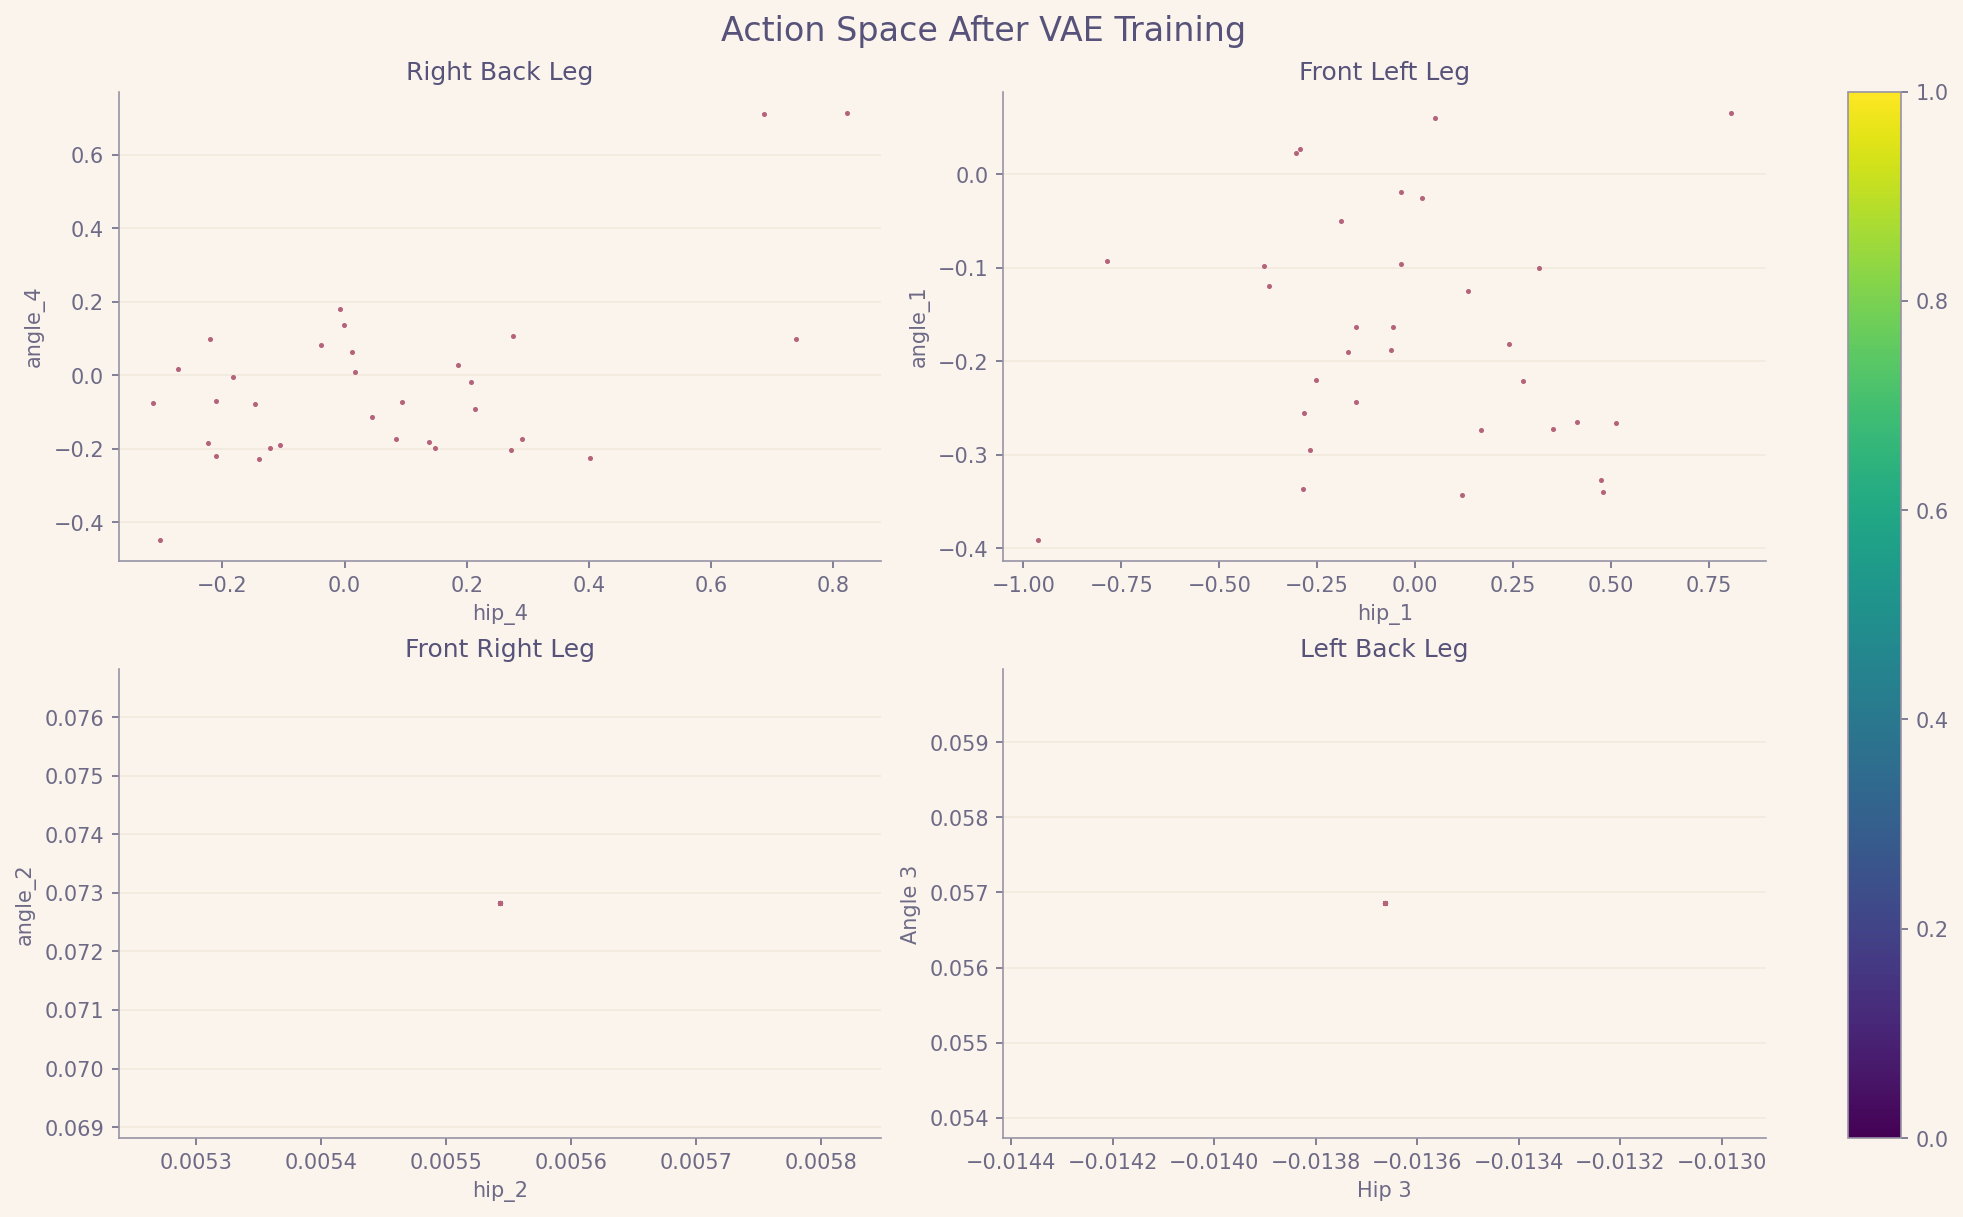

In [242]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_dataloader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in valid_dataloader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(valid_dataloader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

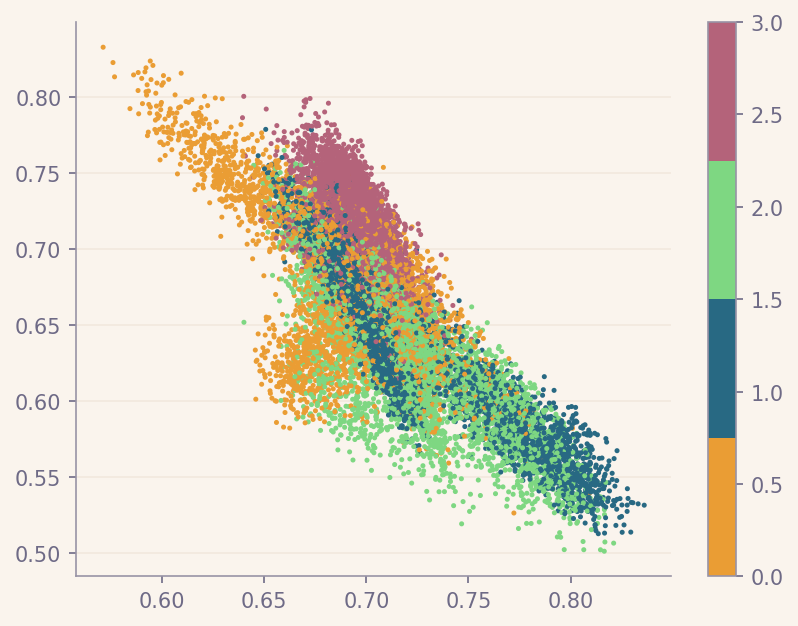

In [243]:
def plot_latent(autoencoder, num_batches=1000):
    """
    Plot the latent space.
    """
    for i, (x, y) in enumerate(dataloader):
        # z, _ = autoencoder.encoder(x.to(device))
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap=cmap, s=2)
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

plot_latent(vae)

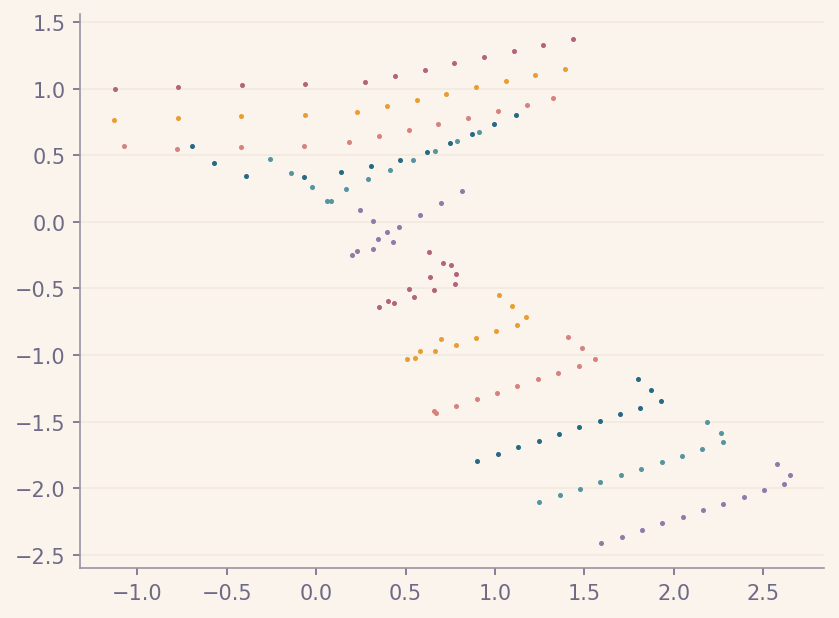

In [244]:
# Plot reconstructed space
def print_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    """
    Plot the reconstructed space.
    """
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            # print(z.shape)
            x_hat = autoencoder.decoder(z)
            # print(x_hat)
            # print(x_hat.shape)
            x = x_hat.to('cpu').detach().numpy()
            plt.scatter(x[:, 0][:, 0], x[:, 0][:, 1], s=2)
            
    plt.show()
            
print_reconstructed(vae)

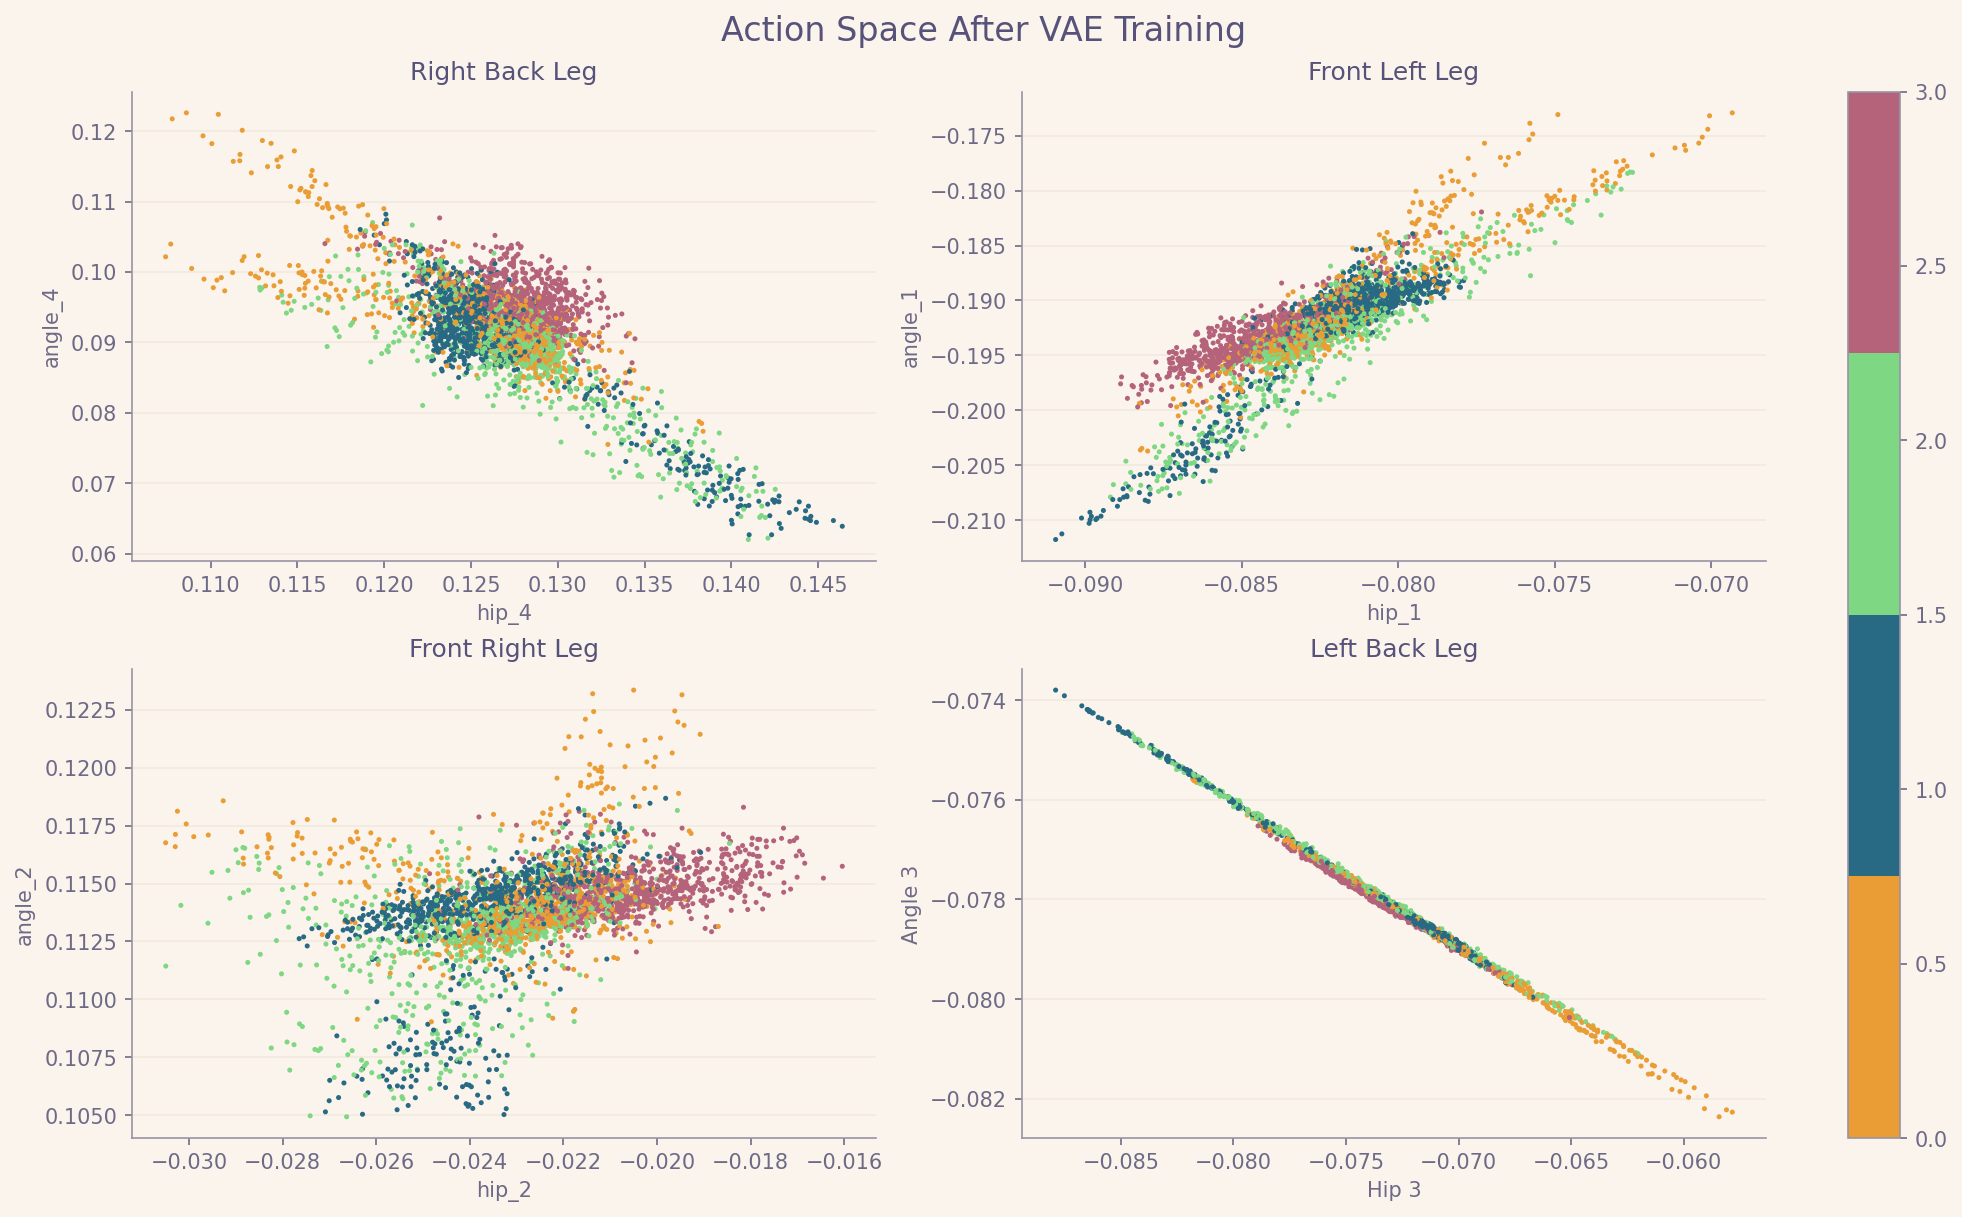

In [245]:
def action_sapce_after(autoencoder, num_batches=100):
    """
    Plot the latent space.
    """
    fig, ax = plt.subplots(2, 2, figsize=(13, 8), constrained_layout=True)

    for i, (x, y) in enumerate(dataloader):
        # z, _ = autoencoder.encoder(x.to(device))
        z = autoencoder.encoder(x.to(device))
        act = autoencoder.decoder(z)
        act = act.to('cpu').detach().numpy()
        x = act
        # x = act.reshape((-1, 1, 8))

        ax[0, 0].scatter(x[:, 0][:, 0], x[:, 0][:, 1], c=y, cmap=cmap, s=2)
        ax[0, 0].set_title('Right Back Leg')
        ax[0, 0].set_xlabel('hip_4')
        ax[0, 0].set_ylabel('angle_4')

        ax[0, 1].scatter(x[:, 0][:, 2], x[:, 0][:, 3], c=y, cmap=cmap, s=2)
        ax[0, 1].set_title('Front Left Leg')
        ax[0, 1].set_xlabel('hip_1')
        ax[0, 1].set_ylabel('angle_1')

        ax[1, 0].scatter(x[:, 0][:, 4], x[:, 0][:, 5], c=y, cmap=cmap, s=2)
        ax[1, 0].set_title('Front Right Leg')
        ax[1, 0].set_xlabel('hip_2')
        ax[1, 0].set_ylabel('angle_2')

        ax[1, 1].scatter(x[:, 0][:, 6], x[:, 0][:, 7], c=y, cmap=cmap, s=2)
        ax[1, 1].set_title('Left Back Leg')
        ax[1, 1].set_xlabel('Hip 3')
        ax[1, 1].set_ylabel('Angle 3')

        
        if i > num_batches:
            break
    # Add main title
    plt.suptitle('Action Space After VAE Training', fontsize=16)

    # Add a legend for the whole figure
    fig.colorbar(ax[0, 0].collections[0], ax=ax.ravel().tolist(), pad=0.05)
    
    # plt.savefig('AppoVariations.png', dpi=300)
    plt.show()
    
    return act
a = action_sapce_after(vae)